In [1]:
import os
import time

from labellines import labelLine
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle, Patch
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn.preprocessing as skp
import torch
from tqdm.notebook import tqdm

from utils import *
from utils.modeling import *
from utils.sine_experiment import *
from utils.optimizers import *

results_dir = os.path.join("Report", "figures")
# report_dir = os.path.join("..", "Retrain or Update Report", "figures")
report_dir = "/Users/jeh/Library/CloudStorage/OneDrive-TheUniversityofTexasatAustin/business/UTexas/projects/Updating Machine Learning Models/Retrain or Update Report/figures"
# report_dir = r"C:\Users\jhamm\OneDrive - The University of Texas at Austin\business\UTexas\projects\Updating Machine Learning Models\Retrain or Update Report\figures"

# sns.set_context("paper")

selection_methods = {
    "threshold": "Magnitude",
    "threshold_abbrev": "Mag.",
    "quantile": "Proportion",
    "quantile_abbrev": "Prop."
}

mm_per_inch = 25.4
mm_to_inch = 1 / mm_per_inch

one_col_width = 89 * mm_to_inch
two_col_width = 183 * mm_to_inch
print(f"One col width: {one_col_width:.2f} in\nTwo col width: {two_col_width:.2f} in")

One col width: 3.50 in
Two col width: 7.20 in


## Subset matrices

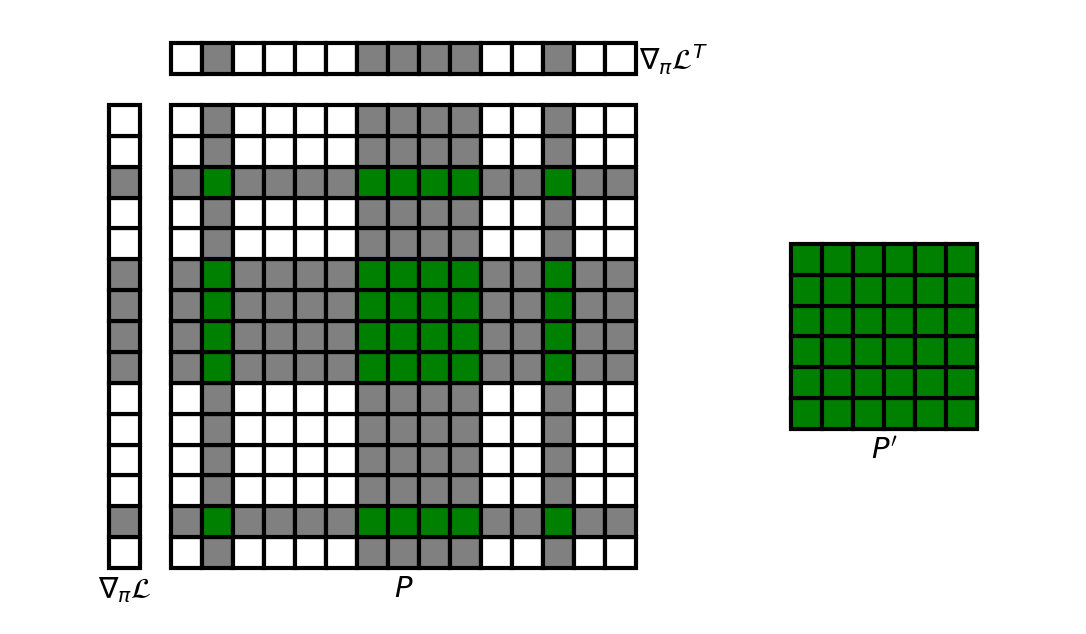

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(one_col_width, 2), layout="constrained", dpi=300)

####################
n = 15
j = [1, 6, 7, 8, 9, 12]
subset_matrix_x_offset = 5
label_offset = 0.2
fs = 7  # fontsize
####################

square_kwargs = {
    "linewidth": 1,
    "edgecolor": "black",
    "width": 1,
    "height": 1
}

# H
for i in range(n):
    if i in j:
        color = "grey"
    else:
        color = "white"
    ax.add_patch(Rectangle((0, i), facecolor=color, **square_kwargs))
ax.annotate(r"$\nabla_\pi\mathcal{L}$", (0.5, -label_offset), fontsize=fs, ha="center", va="top") 
    
# H^T
for i in range(n):
    if i in j:
        color = "grey"
    else:
        color = "white"
    ax.add_patch(Rectangle((2+i, 1+n), facecolor=color, **square_kwargs))
ax.annotate(r"$\nabla_\pi\mathcal{L}^T$", (n+2.1, n+1.5), fontsize=fs, ha="left", va="center")

# P
for i in range(n):
    for k in range(n):
        if (i in j) and (k in j):
            color = "green"
        elif (i in j) or (k in j):
            color = "grey"
        else:
            color = "white"
            
        ax.add_patch(Rectangle((2+i, k), facecolor=color, **square_kwargs))    
ax.annotate(r"$P$", (n/2+2, -label_offset), fontsize=fs, ha="center", va="top")
        
#P'
len_j = len(j)
# center matrix P'
y_buffer = (n - len_j) / 2
for i in range(len_j):
    for k in range(len_j):
        ax.add_patch(Rectangle((2+n+i+subset_matrix_x_offset, y_buffer+k), facecolor="green", **square_kwargs))
ax.annotate(r"$P'$", (2+n+subset_matrix_x_offset+len_j/2, y_buffer-label_offset), fontsize=fs, ha="center", va="top")
        
ax.axis("equal")
ax.set_axis_off()
fig.savefig(os.path.join(report_dir, "subset_matrices_mpl.eps"), dpi=1000)
fig.savefig(os.path.join(report_dir, "subset_matrices_mpl.png"), dpi=1000)
plt.show()

## Two-Timescale System

In [144]:
from utils.modeling import *

results_dir = os.path.join("results", "boundarylayer")
logger = h5_logger(os.path.join(results_dir, "boundary_layer.h5"))

nn = torch.load(os.path.join(results_dir, "initial_nn.pt"), map_location=device, weights_only=False)
n_nn_parameters = get_parameter_vector(nn).shape

boundary layer figures

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_39614/2798264596.py:29: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.05, wspace=0.05)


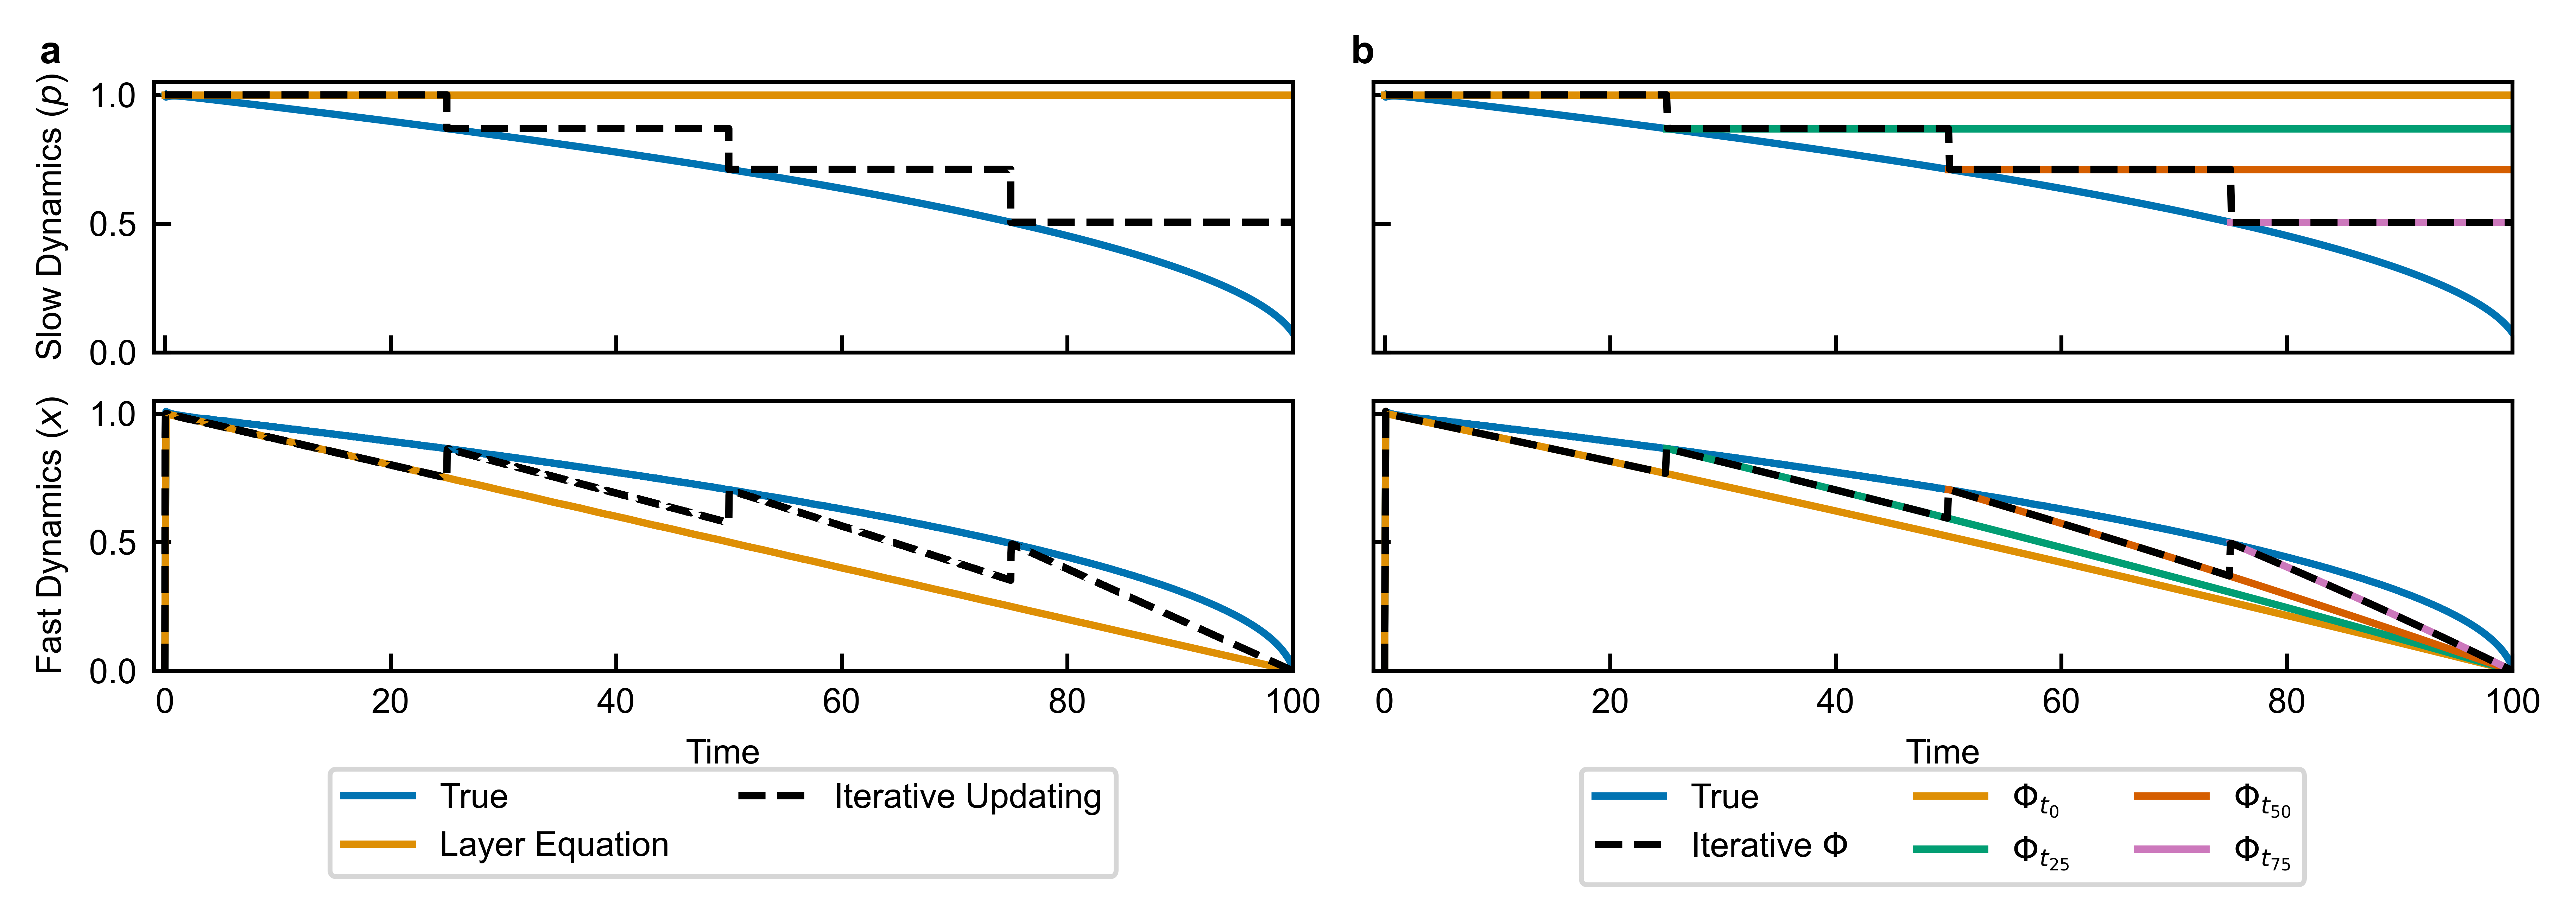

In [145]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(two_col_width, 2.5), dpi=1000)

# left) boundary layer
axs[0,0].plot(logger.get_dataset("example/two_time_scale_solution/t").T,logger.get_dataset("example/two_time_scale_solution/x")[0], label="True")
axs[0,0].plot(logger.get_dataset("example/layer_equation_solution/t").T,logger.get_dataset("example/layer_equation_solution/x")[0], label="Layer Equation")
axs[0,0].plot(logger.get_dataset("example/layer_equation_corr_solution/t").T,logger.get_dataset("example/layer_equation_corr_solution/p_approx").T, color="black", linestyle="--", label='Iterative Updating')

axs[1,0].plot(logger.get_dataset("example/two_time_scale_solution/t").T,logger.get_dataset("example/two_time_scale_solution/x")[1], label="True")
axs[1,0].plot(logger.get_dataset("example/layer_equation_solution/t").T,logger.get_dataset("example/layer_equation_solution/x")[1], label="Layer Equation")
axs[1,0].plot(logger.get_dataset("example/layer_equation_corr_solution/t").T,logger.get_dataset("example/layer_equation_corr_solution/x")[1], color="black", linestyle="--", label='Iterative Updating')

# right) nn approximation
axs[0,1].plot(logger.get_dataset("example/two_time_scale_solution/t").T,logger.get_dataset("example/two_time_scale_solution/x")[0], label="True")
axs[0,1].plot(logger.get_dataset("example/model_t0/t")[1:], logger.get_dataset("example/model_approx/p_approx"), color="k", linestyle="--", label=r'Iterative $\Phi$', zorder=10)
axs[0,1].plot(logger.get_dataset("example/model_t0/t"), np.ones_like(logger.get_dataset("example/model_t0/t"))*logger.get_dataset("example/model_t0/p_approx"), label=r'$\Phi_{t_0}$')
axs[0,1].plot(logger.get_dataset("example/model_t25/t"), np.ones_like(logger.get_dataset("example/model_t25/t"))*logger.get_dataset("example/model_t25/p_approx"), label=r'$\Phi_{t_{25}}$')
axs[0,1].plot(logger.get_dataset("example/model_t50/t"), np.ones_like(logger.get_dataset("example/model_t50/t"))*logger.get_dataset("example/model_t50/p_approx"), label=r'$\Phi_{t_{50}}$')
axs[0,1].plot(logger.get_dataset("example/model_t75/t"), np.ones_like(logger.get_dataset("example/model_t75/t"))*logger.get_dataset("example/model_t75/p_approx"), label=r'$\Phi_{t_{75}}$')

axs[1,1].plot(logger.get_dataset("example/two_time_scale_solution/t").T,logger.get_dataset("example/two_time_scale_solution/x")[1], label="True")
axs[1,1].plot(logger.get_dataset("example/model_t0/t"), logger.get_dataset("example/model_approx/x_approx"), color="k", linestyle="--", label=r'Iterative $\Phi$', zorder=10)
axs[1,1].plot(logger.get_dataset("example/model_t0/t"), logger.get_dataset("example/model_t0/x"), label=r'$\Phi_{t_0}$')
axs[1,1].plot(logger.get_dataset("example/model_t25/t"), logger.get_dataset("example/model_t25/x"), label=r'$\Phi_{t_{25}}$')
axs[1,1].plot(logger.get_dataset("example/model_t50/t"), logger.get_dataset("example/model_t50/x"), label=r'$\Phi_{t_{50}}$')
axs[1,1].plot(logger.get_dataset("example/model_t75/t"), logger.get_dataset("example/model_t75/x"), label=r'$\Phi_{t_{75}}$')


# figure settings
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# axs[0,0].set_title("ODE Solution")
axs[0,0].set_ylabel(r"Slow Dynamics ($p$)")
axs[0,0].set_ylim([0, 1.05])

axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel(r"Fast Dynamics ($x$)")
axs[1,0].set_xlim(-1, logger.get_dataset("example/layer_equation_corr_solution/t").T[-1])
axs[1,0].set_ylim([0, 1.05])
# axs[0,0].legend(loc="lower left", ncol=1)
axs[1,0].legend(loc="upper center", ncol=2, bbox_to_anchor=(0.5, -0.3))

# axs[0,1].set_title("Neural Network Approximation")

axs[1,1].set_xlim(-1, logger.get_dataset("example/layer_equation_corr_solution/t").T[-1])
axs[1,1].set_xlabel("Time")
# axs[0,1].legend(loc="lower left", ncol=2)
axs[1,1].legend(loc="upper center", ncol=3, bbox_to_anchor=(0.5, -0.3))

axs[0,0].annotate("a", xy=(-0.1, 1.07), xycoords="axes fraction", fontsize=8, fontweight="bold")
axs[0,1].annotate("b", xy=(-0.02, 1.07), xycoords="axes fraction", fontsize=8, fontweight="bold")

fig.savefig(os.path.join(report_dir, "boundary_layer.eps"))


one figure draft

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_39614/536555976.py:24: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.05, wspace=0.05)


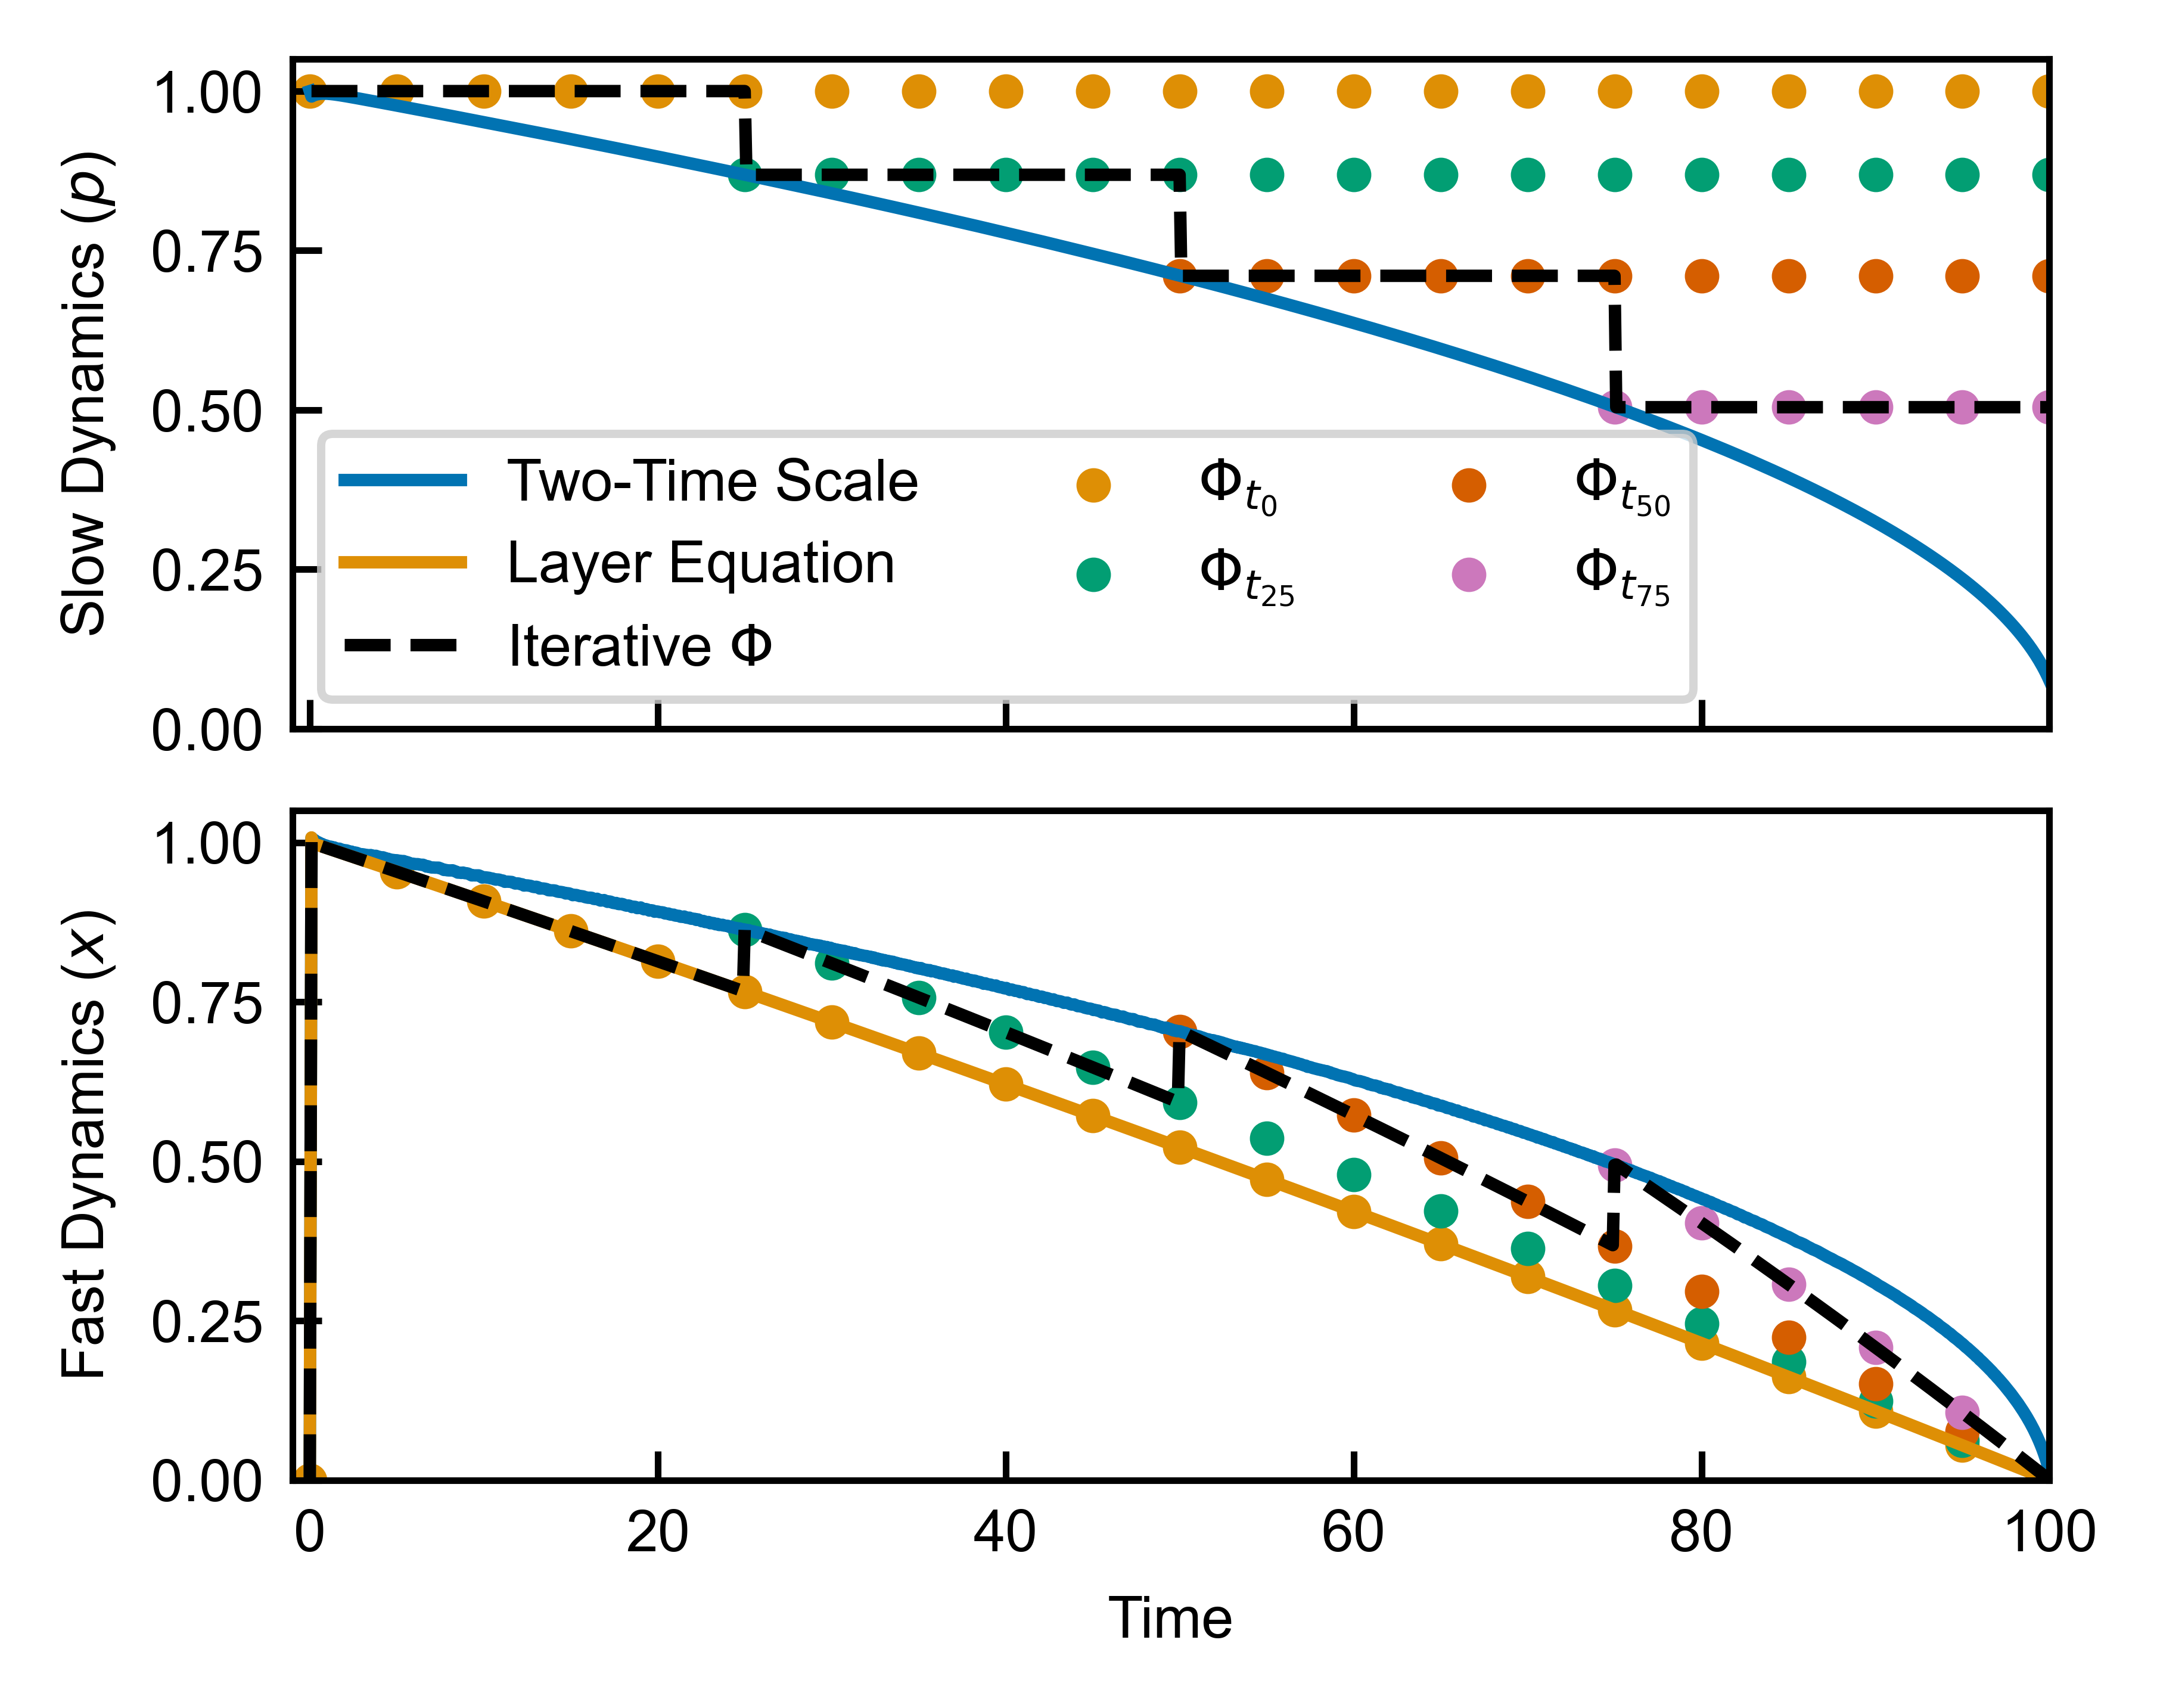

In [84]:
marker_frequency = 50
marker_size = 10
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(one_col_width, 2.75), dpi=1000, layout="constrained", gridspec_kw=dict(hspace=0.05))

axs[0].plot(logger.get_dataset("example/two_time_scale_solution/t").T,logger.get_dataset("example/two_time_scale_solution/x")[0], label="Two-Time Scale")
axs[0].plot(logger.get_dataset("example/model_t0/t")[1:], logger.get_dataset("example/model_approx/p_approx"), color="k", linestyle="--")
axs[0].scatter(logger.get_dataset("example/model_t0/t")[::marker_frequency], np.ones_like(logger.get_dataset("example/model_t0/t")[::marker_frequency])*logger.get_dataset("example/model_t0/p_approx"), s=marker_size, color=colors[1])
axs[0].scatter(logger.get_dataset("example/model_t25/t")[::marker_frequency], np.ones_like(logger.get_dataset("example/model_t25/t")[::marker_frequency])*logger.get_dataset("example/model_t25/p_approx"), s=marker_size, color=colors[2])
axs[0].scatter(logger.get_dataset("example/model_t50/t")[::marker_frequency], np.ones_like(logger.get_dataset("example/model_t50/t")[::marker_frequency])*logger.get_dataset("example/model_t50/p_approx"), s=marker_size, color=colors[3])
axs[0].scatter(logger.get_dataset("example/model_t75/t")[::marker_frequency], np.ones_like(logger.get_dataset("example/model_t75/t")[::marker_frequency])*logger.get_dataset("example/model_t75/p_approx"), s=marker_size, color=colors[4])


axs[1].plot(logger.get_dataset("example/two_time_scale_solution/t").T,logger.get_dataset("example/two_time_scale_solution/x")[1], label="Two-Time Scale")
axs[1].plot(logger.get_dataset("example/model_t0/t"), logger.get_dataset("example/model_t0/x"), label=r'Layer Equation')
axs[1].plot(logger.get_dataset("example/model_t0/t"), logger.get_dataset("example/model_approx/x_approx"), color="k", linestyle="--", label=r'Iterative $\Phi$')
axs[1].scatter(logger.get_dataset("example/model_t0/t")[::marker_frequency], logger.get_dataset("example/model_t0/x")[::marker_frequency], label=r'$\Phi_{t_0}$', s=marker_size, color=colors[1])
axs[1].scatter(logger.get_dataset("example/model_t25/t")[::marker_frequency], logger.get_dataset("example/model_t25/x")[::marker_frequency], label=r'$\Phi_{t_{25}}$', s=marker_size, color=colors[2])
axs[1].scatter(logger.get_dataset("example/model_t50/t")[::marker_frequency], logger.get_dataset("example/model_t50/x")[::marker_frequency], label=r'$\Phi_{t_{50}}$', s=marker_size, color=colors[3])
axs[1].scatter(logger.get_dataset("example/model_t75/t")[::marker_frequency], logger.get_dataset("example/model_t75/x")[::marker_frequency], label=r'$\Phi_{t_{75}}$', s=marker_size, color=colors[4])

# figure settings
fig.subplots_adjust(hspace=0.05, wspace=0.05)

axs[0].set_ylabel(r"Slow Dynamics ($p$)")
axs[0].set_ylim([0, 1.05])

axs[1].set_xlabel("Time")
axs[1].set_ylabel(r"Fast Dynamics ($x$)")
axs[1].set_xlim(-1, logger.get_dataset("example/layer_equation_corr_solution/t").T[-1])
axs[1].set_ylim([0, 1.05])
# axs[1].legend(loc="upper left", ncol=1, bbox_to_anchor=(1.03, 2))
handles, labels = axs[1].get_legend_handles_labels()
axs[0].legend(handles, labels, loc="lower left", ncol=3)

axs[1].set_xlim(-1, logger.get_dataset("example/layer_equation_corr_solution/t").T[-1])
axs[1].set_xlabel("Time")


# axs[0].annotate("a", xy=(-0.15, 0.98), xycoords="axes fraction", fontsize=8, fontweight="bold")
# axs[1].annotate("b", xy=(-0.15, 0.98), xycoords="axes fraction", fontsize=8, fontweight="bold")

plt.show()

Results table

In [146]:
# TODO: Abs Validation grads
# TODO: Control error
# abs_valiation_grads = logger.get_dataset("initial_nn/abs_validation_grads")
abs_validation_grads = np.linspace(0, 0.1, 1000)

mask_functions = {
    "All Parameters": mask_fn,
    # "No Parameters": lambda x: torch.zeros_like(x, dtype=torch.bool),
    "Prop.99": lambda x: mask_fn(x, quantile_thresh=0.99),
    "Prop.95": lambda x: mask_fn(x, quantile_thresh=0.95),
    "Prop.90": lambda x: mask_fn(x, quantile_thresh=0.90),
    "Prop.75": lambda x: mask_fn(x, quantile_thresh=0.75),
    "Prop.50": lambda x: mask_fn(x, quantile_thresh=0.50),
    "Mag.99": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.99)),
    "Mag.95": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.95)),
    "Mag.90": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.90)),
    "Mag.75": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.75)),
    "Mag.50": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.50))
}
learning_rates = [0.1, 0.01, 0.001, 0.0001]

def get_lowest_error(logger, method, parameters, begin_index=200):
    learning_rates = logger.get_keys(f"{method}/{parameters}")
    errors = {lr: np.mean(np.abs(logger.get_dataset(f"{method}/{parameters}/{lr}/e"))[begin_index:]) for lr in learning_rates}
    best_lr = min(errors, key=errors.get)
    return best_lr, errors, logger.get_dataset(f"{method}/{parameters}/{best_lr}/e"), logger.get_dataset(f"{method}/{parameters}/{best_lr}/t")

methods = ["SEKF", "Online Adam", "Retraining", "Finetuning"]
parameters = list(mask_functions.keys())
best_lrs = {method: {param: get_lowest_error(logger, method, param) for param in parameters} for method in methods}

table_rows = []
table_rows.append(["Training", "-", "-", get_ci(np.abs(logger.get_dataset("control/error"))[:150])[0], get_ci(np.abs(logger.get_dataset("control/error"))[:150])[1][0], "-", "-"])
table_rows.append(["Validation", "-", "-", get_ci(np.abs(logger.get_dataset("control/error"))[150:200])[0], get_ci(np.abs(logger.get_dataset("control/error"))[150:200])[1][0], "-", "-"])
table_rows.append(["No Maintenance", "-", "-", get_ci(np.abs(logger.get_dataset("control/error"))[200:])[0], get_ci(np.abs(logger.get_dataset("control/error"))[200:])[1][0], "-", "-"])
begin_index = 200
for method, method_results in best_lrs.items():
    for param, (lr, errors, errors_array, time_array) in method_results.items():
        table_rows.append([method, param, lr, get_ci(np.abs(errors_array[begin_index:]))[0], get_ci(np.abs(errors_array[begin_index:]))[1], get_ci(time_array[begin_index:])[0], get_ci(time_array[begin_index:])[1]])
df = pd.DataFrame(table_rows, columns=["Method", "Parameters", "Best Learning Rate", "MAE", "95\% CI", "Mean Time Per Iteration (s)", "95\% CI"])
df.to_latex(os.path.join(results_dir, "boundary_layer_table.tex"), index=False, escape=True, float_format="%.4e")
df.head()

Method      Parameters Best Learning Rate       MAE   95\% CI  \
0        Training               -                  -  0.000717  0.000158   
1      Validation               -                  -  0.001222  0.000182   
2  No Maintenance               -                  -  0.121567  0.008576   
3            SEKF  All Parameters                0.1  0.000944  0.000072   
4            SEKF         Prop.99                0.1  0.000961  0.000075   

  Mean Time Per Iteration (s)   95\% CI  
0                           -         -  
1                           -         -  
2                           -         -  
3                    0.001404  0.000034  
4                    0.001815  0.000047

scatterplot

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_39614/502493862.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  param_df.sort_values("MAE", ascending=True, inplace=True)


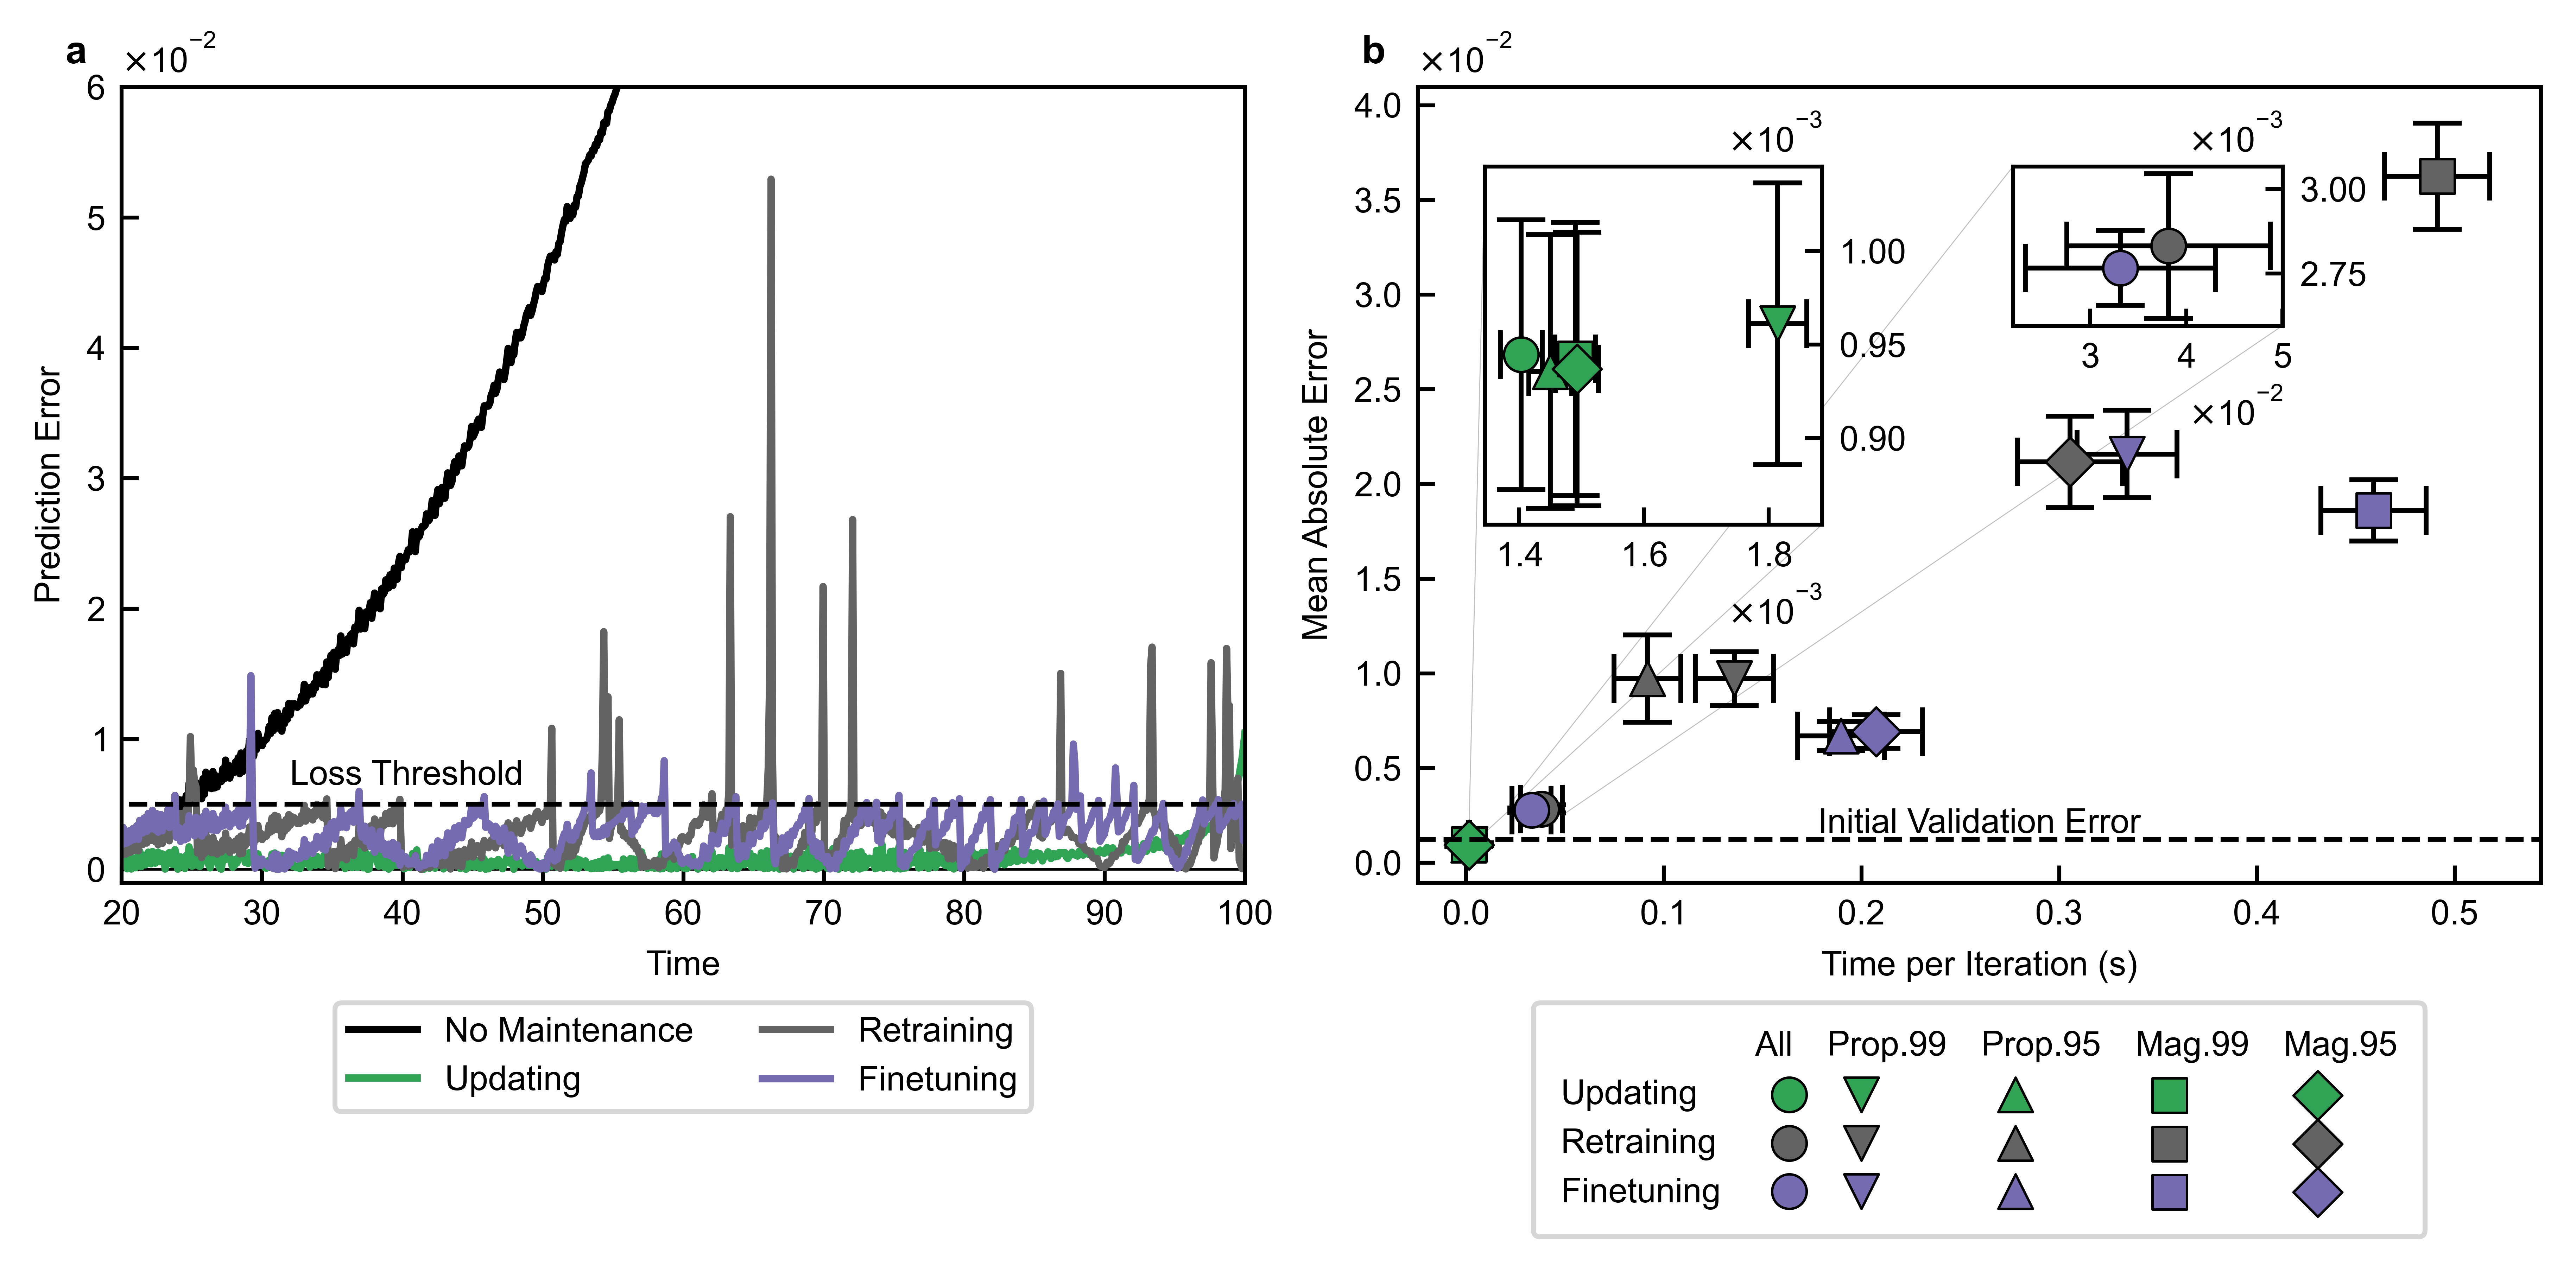

In [88]:
method_args = {
    # "Online Adam": {"color": emph_colors[0]},
    "SEKF": {"color": kalman_colors[0]},
    "Retraining": {"color": true_colors[0]},
    "Finetuning": {"color": adam_colors[0]}
}

mask_functions = {
    "All Parameters": "o",
    # "No Parameters": lambda x: torch.zeros_like(x, dtype=torch.bool),
    "Prop.99": "v",
    "Prop.95": "^",
    # "Prop.90": lambda x: mask_fn(x, quantile_thresh=0.90),
    # "Prop.75": lambda x: mask_fn(x, quantile_thresh=0.75),
    # "Prop.50": lambda x: mask_fn(x, quantile_thresh=0.50),
    "Mag.99": "s",
    "Mag.95": "D",
    # "Mag.90": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.90)),
    # "Mag.75": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.75)),
    # "Mag.50": lambda x: mask_fn(x, thresh=np.quantile(abs_validation_grads, 0.50))
}

handles = []

# for two side-by-side figures
fig, ax = plt.subplots(1,2,figsize=(two_col_width, 3.5), dpi=1000)
# for two figures in a column
# fig, ax = plt.subplots(2,1,figsize=(one_col_width, 130 * mm_to_inch), dpi=1000, gridspec_kw={"height_ratios": [1, 1.7]})

axins1 = ax[1].inset_axes([0.53, 0.70, 0.24, 0.2])
# axins1 = ax[1].inset_axes([0.55, 0.21, 0.22, 0.2])
axins2 = ax[1].inset_axes([0.06, 0.45, 0.3, 0.45])
ax[0].plot(np.linspace(20,100,800), np.abs(logger.get_dataset("control/error"))[begin_index:,0], color="black", label="No Maintenance")
for method, method_params in method_args.items():
    method_color = method_params["color"]
    method_df = df[df["Method"] == method].copy()
    method_df.sort_values("MAE", ascending=True, inplace=True)
    
    # subset parameters result
    best_subset_parameters = method_df[method_df["Parameters"] != "All Parameters"].iloc[0]["Parameters"]
    best_subset_lr = method_df[method_df["Parameters"] != "All Parameters"].iloc[0]["Best Learning Rate"]
    subset_parameters_e = np.abs(logger.get_dataset(f"{method}/{best_subset_parameters}/{best_subset_lr}/e"))[begin_index:]
    subset_parameters_t = logger.get_dataset(f"{method}/{best_subset_parameters}/{best_subset_lr}/t")[begin_index:]
    # plot_ci(subset_parameters_t, subset_parameters_e, ax, color=method_color, marker_fmt="s")
    
    # plot all parameters result
    all_parameters_lr = method_df[method_df["Parameters"] == "All Parameters"]["Best Learning Rate"].values[0]
    all_parameters_e = np.abs(logger.get_dataset(f"{method}/All Parameters/{all_parameters_lr}/e"))[begin_index:]
    all_parameters_t = logger.get_dataset(f"{method}/All Parameters/{all_parameters_lr}/t")[begin_index:]
    # plot_ci(all_parameters_t, all_parameters_e, ax, color=method_color)
    
    # best result lineplot
    best_parameters = method_df.iloc[0]["Parameters"]
    best_lr = method_df.iloc[0]["Best Learning Rate"]
    best_parameters_e = np.abs(logger.get_dataset(f"{method}/{best_parameters}/{best_lr}/e"))[begin_index:]
    best_parameters_t = logger.get_dataset(f"{method}/{best_parameters}/{best_lr}/t")[begin_index:]
    if method == "SEKF":
        method_ = "Updating"
    else:
        method_ = method
    ax[0].plot(np.linspace(20,100,800), best_parameters_e, color=method_color, label=method_)
    
    # plot scatterplots
    method_handles = []
    for param_selection_method, marker in mask_functions.items():
        param_df = method_df[method_df["Parameters"] == param_selection_method]
        param_df.sort_values("MAE", ascending=True, inplace=True)
        if len(param_df) == 0:
            continue
        best_lr = param_df.iloc[0]["Best Learning Rate"]
        e = np.abs(logger.get_dataset(f"{method}/{param_selection_method}/{best_lr}/e"))[begin_index:]
        t = logger.get_dataset(f"{method}/{param_selection_method}/{best_lr}/t")[begin_index:]
        method_handles.append(plot_ci(t, e, ax=ax[1], color=method_color, marker_fmt=marker))
        if method != "SEKF":
            if param_selection_method == "All Parameters":
                plot_ci(t, e, axins1, color=method_color, )
        if method == "SEKF":
            plot_ci(t, e, axins2, color=method_color, marker_fmt=marker)
        
    handles.append(method_handles)
    
# ax0 stuff
ax[0].hlines(0.005, 0, 810, color="black", linestyle="--", linewidth=1.0)
ax[0].annotate("Loss Threshold", (32, 0.006), color="black", ha="left", va="bottom")
ax[0].hlines(0, 0, 810, color="black", linestyle="-", linewidth=0.5, zorder=0)

ax[0].set_xlim(20, 100)
ax[0].set_ylim(-.001, 0.06)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Prediction Error")
ax[0].ticklabel_format(axis='y', style='sci', scilimits=(-2,2), useMathText=True)
# ax[0].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: f"{(x+200)/10:.0f}"))
# ax[0].legend(ncol=2, bbox_to_anchor=(0.5, -0.25), loc="upper center")
ax[0].legend(ncol=2, bbox_to_anchor=(0.5, -0.13), loc="upper center")

# ax1 stuff
xlim = ax[1].get_xlim()
ax[1].hlines(df.iloc[1]["MAE"], xlim[0], xlim[1], color="black", linestyle="--", linewidth=1.0)
ax[1].annotate("Initial Validation Error", (xlim[0] + 0.5*(xlim[1]-xlim[0]), df.iloc[1]["MAE"]), color="black", ha="center", va="bottom")
ax[1].set_xlim(xlim)

# # tick labels
ax[1].ticklabel_format(axis='y', style='sci', scilimits=(-2,2), useMathText=True)
ax[1].set_xlabel("Time per Iteration (s)")
ax[1].set_ylabel("Mean Absolute Error")

# inset tick labels
axins1.yaxis.tick_right()
axins1.ticklabel_format(axis='both', style='sci', scilimits=(-2,2), useMathText=True)
axins2.yaxis.tick_right()
axins2.ticklabel_format(axis='both', style='sci', scilimits=(-2,2), useMathText=True)
# axins2.yaxis.set_major_locator(mpl.ticker.LinearLocator(5))
# axins2.set_yticks([9e-4, 9.5e-4, 1e-3,])
# axins2.set_xticks([0.0015, 0.0017])
ax[1].indicate_inset_zoom(axins1, edgecolor="grey", zorder=0, linewidth=0.2)
ax[1].indicate_inset_zoom(axins2, edgecolor="grey", zorder=0, linewidth=0.2)

# legend
empty_handle = Rectangle((0, 0), 1, 1, fc="white", fill=False, edgecolor='none', linewidth=0)

legend_handle, legend_labels, ncol = table_legend(
    np.array(handles),
    row_labels=["Updating", "Retraining", "Finetuning"],
    column_labels=["All", selection_methods["quantile_abbrev"]+"99",
                   selection_methods["quantile_abbrev"]+"95", 
                   selection_methods["threshold_abbrev"]+"99",
                   selection_methods["threshold_abbrev"]+"95"]
)
ax[1].legend(legend_handle, legend_labels, ncol=ncol, 
    columnspacing=1.0, borderpad=0.8, handletextpad = -2,
    bbox_to_anchor = (0.5, -0.13),  loc = "upper center")

# figure labels
ax[0].annotate("a", xy=(-0.05, 1.03), xycoords="axes fraction", fontsize=8, fontweight="bold")
ax[1].annotate("b", xy=(-0.05, 1.03), xycoords="axes fraction", fontsize=8, fontweight="bold")

fig.savefig(os.path.join(report_dir, "boundary_layer_results_twocol.eps"), bbox_inches='tight')
plt.show()

summary results table

In [78]:
table_rows = []
table_rows.append(["Training", "-", "-", get_ci(np.abs(logger.get_dataset("control/error"))[:150])[0], get_ci(np.abs(logger.get_dataset("control/error"))[:150])[1][0], "-", "-"])
table_rows.append(["Validation", "-", "-", get_ci(np.abs(logger.get_dataset("control/error"))[150:200])[0], get_ci(np.abs(logger.get_dataset("control/error"))[150:200])[1][0], "-", "-"])
table_rows.append(["No Maintenance", "-", "-", get_ci(np.abs(logger.get_dataset("control/error"))[200:])[0], get_ci(np.abs(logger.get_dataset("control/error"))[200:])[1][0], "-", "-"])

for method, method_params in method_args.items():
    method_df = df[df["Method"] == method].copy()
    method_df.sort_values("MAE", ascending=True, inplace=True)
    
    # subset parameters result
    best_subset_parameters = method_df[method_df["Parameters"] != "All Parameters"].iloc[0]["Parameters"]
    best_subset_lr = method_df[method_df["Parameters"] != "All Parameters"].iloc[0]["Best Learning Rate"]
    subset_parameters_e = np.abs(logger.get_dataset(f"{method}/{best_subset_parameters}/{best_subset_lr}/e"))[begin_index:]
    subset_parameters_t = logger.get_dataset(f"{method}/{best_subset_parameters}/{best_subset_lr}/t")[begin_index:]
    
    # plot all parameters result
    all_parameters_lr = method_df[method_df["Parameters"] == "All Parameters"]["Best Learning Rate"].values[0]
    all_parameters_e = np.abs(logger.get_dataset(f"{method}/All Parameters/{all_parameters_lr}/e"))[begin_index:]
    all_parameters_t = logger.get_dataset(f"{method}/All Parameters/{all_parameters_lr}/t")[begin_index:]
    
    # append to summary table
    table_rows.append([method, "All Parameters", all_parameters_lr, get_ci(all_parameters_e)[0], get_ci(all_parameters_e)[1], get_ci(all_parameters_t)[0], get_ci(all_parameters_t)[1]])
    table_rows.append([method, best_subset_parameters, best_subset_lr, get_ci(subset_parameters_e)[0], get_ci(subset_parameters_e)[1], get_ci(subset_parameters_t)[0], get_ci(subset_parameters_t)[1]])

df = pd.DataFrame(table_rows, columns=["Method", "Parameters", "Best Learning Rate", "MAE", "95\% CI", "Mean Time Per Iteration (s)", "95\% CI"])
df.to_latex(os.path.join(results_dir, "summary_table.tex"), index=False, escape=True, float_format="%.4e")

## CSTR

In [89]:
logger = h5_logger(os.path.join("results", "CSTR", "data.h5"))
_, n_params = logger.get_dataset("training/grads").shape
n_outputs = 180
s_jacobian = n_params * n_outputs
print(f"Number of inputs: 63 (3+60)")
print(f"Number of outputs: {n_outputs}")
print(f"Number of parameters: {n_params:3,d}")
print(f"Number of elements in Jacobian: {s_jacobian:3,d}")

from utils.cstr_experiment import format_dataset

results_dir = os.path.join("results", "CSTR")

logger = h5_logger(os.path.join(results_dir, "data.h5"))

sim_minutes = 36 * 60
train_minutes = 24 * 60
val_minutes = 6 * 60
test_minutes = 6 * 60

input_horizon = 1  # Np
prediction_horizon = 60
batch_size = 100
nx = 3
nu = 1

Xscaler = skp.StandardScaler()
Uscaler = skp.StandardScaler()
Xscaler.fit(logger.get_dataset("training/values/sim_5_data/Y")[0])
Uscaler.fit(logger.get_dataset("training/values/sim_5_data/U")[0])

process_tspan = np.linspace(0, sim_minutes, sim_minutes+1)
process_u = logger.get_dataset("training/values/sim_5_data/U")[0]
process_x0 = np.array([0.33333333, 0.47851534, 0.38994523])
process_noise = np.array([5e-4, 1e-4, 1e-4])

sim_5_data = {
    "X": logger.get_dataset("training/values/sim_5_data/Y")[0],
    "U": logger.get_dataset("training/values/sim_5_data/U")[0],
    "Y": logger.get_dataset("training/values/sim_5_data/Y")[0]
}

y_ticks_formatter = mpl.ticker.StrMethodFormatter("{x:,.2f}")
species_labels = [r"$C_A$", r"$C_B$", r"$C_C$"]

Number of inputs: 63 (3+60)
Number of outputs: 180
Number of parameters: 419
Number of elements in Jacobian: 75,420


individual prediction

Scaled Prediction MSE:
Original Model: 0.646
Adam (All): 0.042
Kalman (All): 0.031


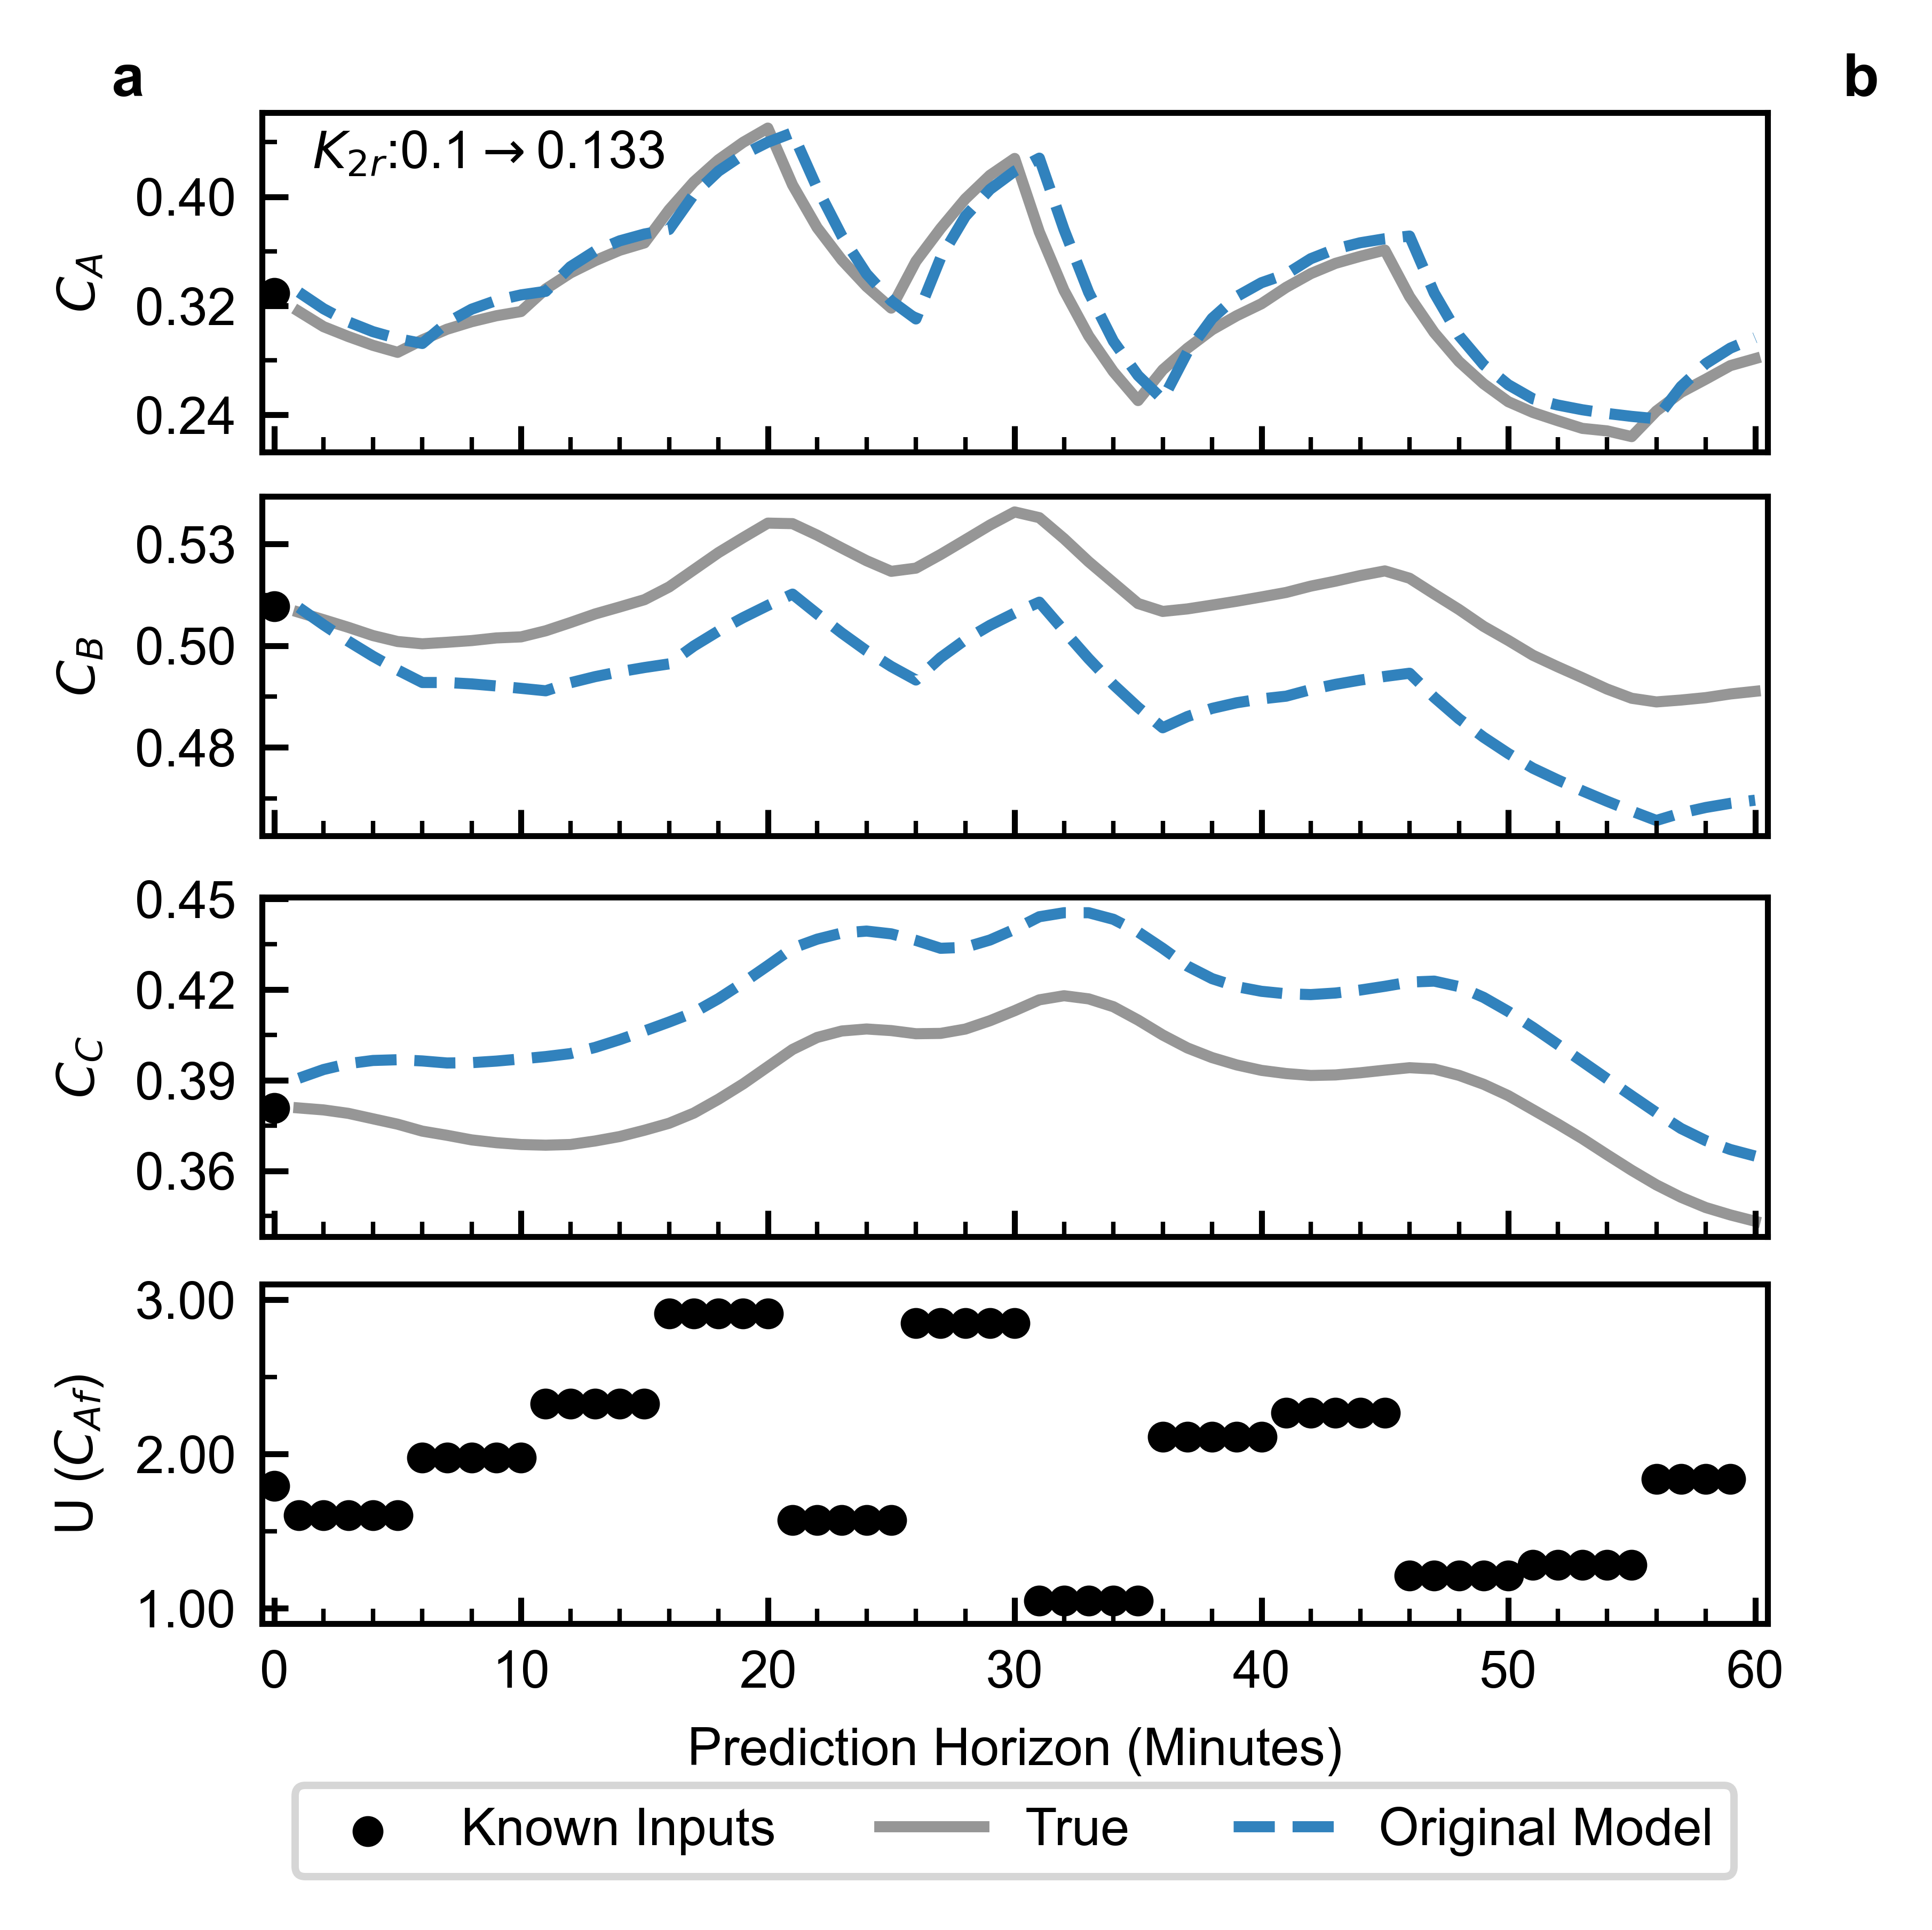

In [91]:
prediction_index = 1099
k2r = 1e-1+3e-5*prediction_index

### Data ###
# Dataset/scaling
sim_drifting_data = {
    "X": logger.get_dataset("updating/values/x")[0],
    "Y": logger.get_dataset("updating/values/y")[0],
    "U": logger.get_dataset("updating/values/u").T,
}
drifting_dataset = format_dataset(sim_drifting_data, Xscaler, Uscaler, begin_index=0, end_index=-1, nx=nx, input_horizon=input_horizon, train=False, name="drifting", device=device)
# get scaled (x_) and unscaled (x) data
# True
xn = Xscaler.inverse_transform(drifting_dataset["xn"][prediction_index].cpu().numpy())
u = Uscaler.inverse_transform(drifting_dataset["u"][prediction_index].cpu().numpy())
y_ = drifting_dataset["y"][prediction_index].cpu().numpy()
y = Xscaler.inverse_transform(y_)
# control
yp_control_ = logger.get_dataset("updating/control/yp")[prediction_index, 0]
yp_control = Xscaler.inverse_transform(yp_control_)
# Adam (all)
yp_adam_all_ = logger.get_dataset("updating/adam-all/0.001/yp")[prediction_index, 0]
yp_adam_all = Xscaler.inverse_transform(yp_adam_all_)
# SEKF (all)
yp_sekf_all_ = logger.get_dataset("updating/kf-all/0.0003/yp")[prediction_index, 0]
yp_sekf_all = Xscaler.inverse_transform(yp_sekf_all_)

### Figure ###
fig, ax = plt.subplots(4, 1, figsize=(89*mm_to_inch, 3.5), sharex=True, dpi=1000, gridspec_kw=dict(hspace=0.02))
y_ticks_formatter = mpl.ticker.StrMethodFormatter("{x:,.2f}")
species_labels = [r"$C_A$", r"$C_B$", r"$C_C$"]
scatter_kwargs = {"color":"k", "zorder":1, "s":10}
for species in range(3):
    # true = ax[species].scatter(np.arange(1, prediction_horizon+1), y[:, species], color=true_colors[1], zorder=0)
    true, = ax[species].plot(np.arange(1, prediction_horizon+1), y[:, species], color=true_colors[1], linestyle="-", zorder=1)    
    # kf, = ax[species].plot(np.arange(1, prediction_horizon+1), yp_sekf_all[:, species], color=kalman_colors[0], linestyle="-.",  zorder=1)
    # adam, = ax[species].plot(np.arange(1, prediction_horizon+1), yp_adam_all[:, species], color=adam_colors[0], linestyle="--",  zorder=1)
    control,  = ax[species].plot(np.arange(1, prediction_horizon+1), yp_control[:, species], color=model_colors[0], linestyle="--",  zorder=1)
    initial = ax[species].scatter(0, xn[:,species], **scatter_kwargs)
    # ax[species].set_ylim(np.min(y)-0.02, np.max(y)+0.02)
    # ax[species].set_yticks(np.arange(0.15, 0.45, 0.05))
    ax[species].yaxis.set_major_locator(MaxNLocator(4))
    ax[species].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax[species].yaxis.set_major_formatter(y_ticks_formatter)
    ax[species].set_xticks(np.arange(0, 70, 10))
    ax[species].set_xticks(np.arange(0, 61, 2), minor=True)
    ax[species].set_ylabel(species_labels[species])
    ax[species].yaxis.set_major_formatter(y_ticks_formatter)
    ax[species].set_xlim(-0.5, prediction_horizon+0.5)

# graph U
# ax[-1].step(np.arange(0, prediction_horizon), u, color="k", where="pre", zorder=1)
ax[-1].scatter(np.arange(0, prediction_horizon), u, **scatter_kwargs)
ax[-1].set_ylim(0.9, 3.1)
ax[-1].yaxis.set_major_formatter(y_ticks_formatter)
ax[-1].yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax[-1].set_ylabel(r"U ($C_{Af}$)")
ax[-1].set_xlabel("Prediction Horizon (Minutes)")

original_mse = np.mean((y_-yp_control_)**2)
retraining_mse = np.mean((y_-yp_adam_all_)**2)
sekf_mse = np.mean((y_-yp_sekf_all_)**2)
# legend_handles = [initial, true, control, adam, kf]
# legend_labels = ["Known Inputs", "True", "Original Model", "Retraining (All)", "SEKF (All)"]
legend_handles = [initial, true, control]
legend_labels = ["Known Inputs", "True", "Original Model"]

# legend underneath, minimal text
ax[-1].legend(legend_handles, legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.4), ncol=3)
ax[0].text(2/60, 0.95, r"$K_{2r}$:0.1$\rightarrow$"+f"{k2r:.3f}", verticalalignment="top", horizontalalignment="left", transform=ax[0].transAxes)
print("Scaled Prediction MSE:")
print(f"Original Model: {original_mse:.3f}")
print(f"Adam (All): {retraining_mse:.3f}")
print(f"Kalman (All): {sekf_mse:.3f}")

ax[0].annotate("a", xy=(-0.1, 1.05), xycoords="axes fraction", fontsize=8, fontweight="bold")
ax[0].annotate("b", xy=(1.05, 1.05), xycoords="axes fraction", fontsize=8, fontweight="bold")

# fig.savefig(os.path.join(results_dir, "cstr_prediction.pdf"), bbox_inches='tight')
fig.savefig(os.path.join(report_dir, "cstr_prediction.eps"))
plt.show()

results table

In [92]:
# mean_control_loss, ci_control_loss = get_ci(logger.get_dataset("updating/control/loss")[:,0])
control_loss = logger.get_dataset("updating/control/loss")[:,0]

def row_stats(method, parameters, results_string):
    loss_values = logger.get_dataset(f"updating/{results_string}/loss")[:,0]
    time_values = np.diff(logger.get_dataset(f"updating/{results_string}/time")[:,0], prepend=0)
    fss_values = 1 - (loss_values / control_loss)
    return [method, parameters, *get_ci(loss_values), *get_ci(fss_values), *get_ci(time_values)]

df_rows = []
df_cols = ["Method", "Params.", "MSE", "95%CI", "FSS", "95%CI", "Mean Time (s)", "95%CI"]
df_rows.append(["Training", "-", *get_ci(logger.get_dataset("training/loss/train")[:,0]), "-", "-", "-", "-"])
df_rows.append(["Validation", "-", *get_ci(logger.get_dataset("training/loss/val")[:,0]), "-", "-", "-", "-"])
df_rows.append(["No Maintenance", "-", *get_ci(logger.get_dataset("updating/control/loss")[:,0]), "-", "-", "-", "-"])
# df_rows.append(["Retraining", "All", *get_ci(logger.get_dataset("updating/adam-all/loss")[:,0]), *get_ci(1-(logger.get_dataset("updating/adam-all/time")[:,0]/control_loss)), *get_ci(np.diff(logger.get_dataset("updating/adam-all/time")[:,0], prepend=0))])
df_rows.append(row_stats("Retraining", "All", "adam-all/0.001"))
df_rows.append(row_stats("Retraining", "Prop.(0.99)", "adam-quantile-0.99/0.001"))
df_rows.append(row_stats("Retraining", "Prop.(0.95)", "adam-quantile-0.95/0.001"))
df_rows.append(row_stats("Retraining", "Mag.(0.99)", "adam-thresh-0.99/0.001"))
df_rows.append(row_stats("Retraining", "Mag.(0.95)", "adam-thresh-0.95/0.001"))
df_rows.append(row_stats("Updating", "All", "kf-all/0.0003"))
df_rows.append(row_stats("Updating", "Prop.(0.99)", "kf-quantile-0.99/0.0003"))
df_rows.append(row_stats("Updating", "Prop.(0.95)", "kf-quantile-0.95/0.0003"))
df_rows.append(row_stats("Updating", "Mag.(0.99)", "kf-thresh-0.99/0.0003"))
df_rows.append(row_stats("Updating", "Mag.(0.95)", "kf-thresh-0.95/0.0003"))
df = pd.DataFrame(df_rows, columns=df_cols)
df.to_latex(os.path.join(results_dir, "cstr_table.tex"), index=False, float_format="%.4e", escape=True)
df

Method      Params.       MSE     95%CI       FSS     95%CI  \
0         Training            -  0.088168  0.051032         -         -   
1       Validation            -  0.099257  0.064142         -         -   
2   No Maintenance            -  0.736291  0.025886         -         -   
3       Retraining          All  0.029299  0.000295  0.851344  0.009991   
4       Retraining  Prop.(0.99)  0.040291  0.000635  0.826304  0.010961   
5       Retraining  Prop.(0.95)  0.033487  0.000386  0.841518  0.010287   
6       Retraining   Mag.(0.99)  0.033794  0.000409  0.842736  0.010188   
7       Retraining   Mag.(0.95)  0.031548  0.000333  0.842951  0.010261   
8         Updating          All  0.012471  0.000189  0.925092   0.00615   
9         Updating  Prop.(0.99)  0.012471  0.000189  0.925092   0.00615   
10        Updating  Prop.(0.95)  0.012471  0.000189  0.925092   0.00615   
11        Updating   Mag.(0.99)  0.032104  0.000616  0.877553  0.007709   
12        Updating   Mag.(0.95)  0.021411  0.000343  0.892538  0.007503   

   Mean Time (s)     95%CI  
0              -         -  
1              -         -  
2              -         -  
3       0.188209  0.026034  
4       1.282732   0.06939  
5       0.745761  0.057952  
6        0.79177   0.05891  
7       0.438213   0.04458  
8       0.220292  0.000345  
9       0.219788   0.00034  
10      0.219529  0.000272  
11      0.212838  0.000332  
12      0.213217  0.000333

## FCC

In [94]:
from utils.fcc import NOC_STABLE_PATH, NOC_VARYING_PATH, COLUMNS, X_COLUMNS_NAMES, U_COLUMNS_NAMES, FAULTY_CONDITIONS
from utils.fcc import FCUDataset, DataLoader, graph_subplots

MEASUREMENT_NOISE_LEVEL = 0.0025

sorted_columns = sorted(X_COLUMNS_NAMES) + sorted(U_COLUMNS_NAMES)

fcc_results_dir = os.path.join("results", "fcc")

logger = h5_logger(os.path.join(fcc_results_dir, "Faulty Conditions", "FC_GEKFv2.h5"))

# ---

# import data
df_stable = pd.read_csv(NOC_STABLE_PATH, names=COLUMNS)
df_varying = pd.read_csv(NOC_VARYING_PATH, names=COLUMNS)
df = pd.concat([df_stable, df_varying], ignore_index=True)
# split and scale data
# 7 days train (2 stable, 5 varying) ~78%
# 1 day val ~11%
# 1 day test ~11%
train_val_idx = -2880
val_test_idx = -1440
prediction_horizon = 60
batch_size = 32

if MEASUREMENT_NOISE_LEVEL:
    noise_std = MEASUREMENT_NOISE_LEVEL / 3
    # Add Gaussian noise with st dev of 1/3% of the mean value of each variable
    data = default_rng.standard_normal(df.shape) * MEASUREMENT_NOISE_LEVEL/3 * df.values.mean(axis=0) + df.values

    df = pd.DataFrame(data, columns=df.columns)

X_scaler = skp.RobustScaler()
U_scaler = skp.RobustScaler()

train_dataset = FCUDataset(df, 
    prediction_horizon=prediction_horizon, 
    context_length=1, 
    train=True, 
    X_scaler=X_scaler, 
    U_scaler=U_scaler, 
    begin_split_index=0, 
    end_split_index=train_val_idx)
val_dataset = FCUDataset(df,
    prediction_horizon=prediction_horizon, 
    context_length=1, 
    train=False, 
    X_scaler=X_scaler, 
    U_scaler=U_scaler, 
    begin_split_index=train_val_idx, 
    end_split_index=val_test_idx)
test_dataset = FCUDataset(df,
    prediction_horizon=prediction_horizon, 
    context_length=1, 
    train=False, 
    X_scaler=X_scaler, 
    U_scaler=U_scaler, 
    begin_split_index=val_test_idx)

train_dl = DataLoader(train_dataset, batch_size=128, shuffle=True, generator=torch.Generator(device=device))
val_dl = DataLoader(val_dataset, batch_size=128, shuffle=False, generator=torch.Generator(device=device))
test_dl = DataLoader(test_dataset, batch_size=128, shuffle=False, generator=torch.Generator(device=device))

model = Exogenous_RkRNN(state_dim=len(X_COLUMNS_NAMES), input_dim=len(U_COLUMNS_NAMES), hidden_size=64)
model.load_state_dict(torch.load(os.path.join(fcc_results_dir, "training", "RkRNN_NOC.pth"), map_location=device))
n_params = get_parameter_vector(model).shape[0]
n_inputs = len(X_COLUMNS_NAMES) + len(U_COLUMNS_NAMES) * 60
n_outputs = len(X_COLUMNS_NAMES) * 60
jacobian_size = n_outputs * n_params

print(f"Model Parameters: {n_params:3,d}")
print(f"Model Inputs: {n_inputs:3,d}")
print(f"Model Outputs: {n_outputs:3,d}")
print(f"Jacobian Size: {jacobian_size:3,d}")

# args
data_path = NOC_VARYING_PATH  # NOC_VARYING_PATH or one of FAULTY_CONDITIONS paths
scale = True  # T/F

##########
df_stable = pd.read_csv(NOC_STABLE_PATH, names=COLUMNS)
df_varying = pd.read_csv(data_path, names=COLUMNS)
df = pd.concat([df_stable, df_varying], ignore_index=True)
if scale:
    x_data_scaled = X_scaler.transform(df[X_COLUMNS_NAMES].values)
    u_data_scaled = U_scaler.transform(df[U_COLUMNS_NAMES].values)
    df_x_scaled = pd.DataFrame(x_data_scaled, columns=X_COLUMNS_NAMES)
    df_u_scaled = pd.DataFrame(u_data_scaled, columns=U_COLUMNS_NAMES)
    df = df_x_scaled.join(df_u_scaled)
df = df[sorted_columns]

# add noise
data = default_rng.standard_normal(df.shape) * MEASUREMENT_NOISE_LEVEL/3 * df.values.mean(axis=0) + df.values
dfplot = pd.DataFrame(data, columns=sorted_columns)

# plot 
# fig, axs = graph_subplots(dfplot)

# fig.savefig(os.path.join(results_dir, f"FOC_{k}_data.png"), bbox_inches="tight", dpi=500)
# fig.savefig(os.path.join(results_dir, f"FOC_{k}_data.pdf"), bbox_inches="tight", dpi=1_000)
# fig.savefig(os.path.join(results_dir, f"FOC_{k}_data.svg"), bbox_inches="tight", dpi=500)

Model Parameters: 9,247
Model Inputs: 931
Model Outputs: 1,860
Jacobian Size: 17,199,420


Model Maintenance  

loss for Higher pressure drop and CAB Valve leak are higher. However, the control loss is also higher for these. Coul revisit the retraining as Adam already got tuned quite a bit

results table

In [95]:
training_logger = h5_logger(os.path.join(fcc_results_dir, "training", "NOC_RkRNN.h5"))
training_loss = training_logger.get_dataset("training/loss/train")[:,0]
val_loss = training_logger.get_dataset("training/loss/val")[:,0]

maintenance_methods = ["updating", "retraining"]
parameter_selection_methods = ["full", "t-0.99", "t-0.95", "q-0.99", "q-0.95"]
faulty_conditions = list(FAULTY_CONDITIONS.keys())
data = []
data.append({
                "faulty_condition": "-",
                "maintenance_method": "Training",
                "selection method": "-",
                "attempts": 0,
                "best result": "NA", 
                "loss ci": "-",
                "Fss": "-",
                "Fss ci": "-",
                "time": "-",
                "time ci": "-",
                "loss": get_ci(training_loss)[0],
                "loss ci": get_ci(training_loss)[1],
            })
data.append({
                "faulty_condition": "-",
                "maintenance_method": "Validation",
                "selection method": "-",
                "attempts": 0,
                "best result": "NA", 
                "loss ci": "-",
                "Fss": "-",
                "Fss ci": "-",
                "time": "-",
                "time ci": "-",
                "loss": get_ci(val_loss)[0],
                "loss ci": get_ci(val_loss)[1],
            })
for fc in faulty_conditions:
    loss  = logger.get_dataset(f"updating/{fc}/control/mse_scaled")[0,:]
    row = {
                "faulty_condition": fc,
                "maintenance_method": "No Maintenance",
                "selection method": "-",
                "attempts": 0,
                "best result": "NA", 
                "loss ci": "-",
                "Fss": "-",
                "Fss ci": "-",
                "time": "-",
                "time ci": "-",
            }
    row["loss"], row["loss ci"] = get_ci(loss)
    data.append(row)
for mm in maintenance_methods:
    for fc in faulty_conditions:
        fc_experiments = logger.get_keys(f"{mm}/{fc}/")
        for selection_method in parameter_selection_methods:
            row = {
                "faulty_condition": fc,
                "maintenance_method": mm,
                "selection method": selection_method,
                "loss": 999,
                "time": 999,
                "attempts": 0,
                "best result": "NA"
            }
            matching_experiments = [e for e in fc_experiments if e.startswith(selection_method)]
            for me in matching_experiments:
                logger_header = f"{mm}/{fc}/{me}/"
                if logger.check_key(logger_header+"loss"):
                    control_loss = logger.get_dataset(f"updating/{fc}/control/mse_scaled")[0,:]
                    row["attempts"] += 1
                    loss_data = logger.get_dataset(logger_header+"loss")
                    time_data = np.diff(logger.get_dataset(logger_header+"time")[:,0], prepend=0)
                    if loss_data.shape[0] == 1378:
                        if np.isnan(loss_data).sum() == 0:
                            if loss_data.mean() < row["loss"]:
                                row["loss"], row["loss ci"] = get_ci(loss_data)
                                row["Fss"], row["Fss ci"] = get_ci(1 - (loss_data / control_loss))
                                row["time"], row["time ci"] = get_ci(time_data)
                                row["best result"] = me
                else:
                    logger.recursive_del(logger_header)
            data.append(row)
df = pd.DataFrame(data)
df = df[["faulty_condition", "maintenance_method", "selection method", "loss", "loss ci", "Fss", "Fss ci", "time", "time ci"]]
df = df.sort_values(by=["faulty_condition", "maintenance_method", "selection method"])
df.to_latex(os.path.join(fcc_results_dir, "fcc_table.tex"), index=False, float_format="%.4e")
df

faulty_condition maintenance_method selection method  \
0                                -           Training                -   
1                                -         Validation                -   
6                   CAB Valve Leak     No Maintenance                -   
52                  CAB Valve Leak         retraining             full   
56                  CAB Valve Leak         retraining           q-0.95   
55                  CAB Valve Leak         retraining           q-0.99   
54                  CAB Valve Leak         retraining           t-0.95   
53                  CAB Valve Leak         retraining           t-0.99   
27                  CAB Valve Leak           updating             full   
31                  CAB Valve Leak           updating           q-0.95   
30                  CAB Valve Leak           updating           q-0.99   
29                  CAB Valve Leak           updating           t-0.95   
28                  CAB Valve Leak           updating           t-0.99   
3   Decreased Condenser Efficiency     No Maintenance                -   
37  Decreased Condenser Efficiency         retraining             full   
41  Decreased Condenser Efficiency         retraining           q-0.95   
40  Decreased Condenser Efficiency         retraining           q-0.99   
39  Decreased Condenser Efficiency         retraining           t-0.95   
38  Decreased Condenser Efficiency         retraining           t-0.99   
12  Decreased Condenser Efficiency           updating             full   
16  Decreased Condenser Efficiency           updating           q-0.95   
15  Decreased Condenser Efficiency           updating           q-0.99   
14  Decreased Condenser Efficiency           updating           t-0.95   
13  Decreased Condenser Efficiency           updating           t-0.99   
2           Heat Exchanger Fouling     No Maintenance                -   
32          Heat Exchanger Fouling         retraining             full   
36          Heat Exchanger Fouling         retraining           q-0.95   
35          Heat Exchanger Fouling         retraining           q-0.99   
34          Heat Exchanger Fouling         retraining           t-0.95   
33          Heat Exchanger Fouling         retraining           t-0.99   
7           Heat Exchanger Fouling           updating             full   
11          Heat Exchanger Fouling           updating           q-0.95   
10          Heat Exchanger Fouling           updating           q-0.99   
9           Heat Exchanger Fouling           updating           t-0.95   
8           Heat Exchanger Fouling           updating           t-0.99   
4   Heavy Naptha Flow Sensor Drift     No Maintenance                -   
42  Heavy Naptha Flow Sensor Drift         retraining             full   
46  Heavy Naptha Flow Sensor Drift         retraining           q-0.95   
45  Heavy Naptha Flow Sensor Drift         retraining           q-0.99   
44  Heavy Naptha Flow Sensor Drift         retraining           t-0.95   
43  Heavy Naptha Flow Sensor Drift         retraining           t-0.99   
17  Heavy Naptha Flow Sensor Drift           updating             full   
21  Heavy Naptha Flow Sensor Drift           updating           q-0.95   
20  Heavy Naptha Flow Sensor Drift           updating           q-0.99   
19  Heavy Naptha Flow Sensor Drift           updating           t-0.95   
18  Heavy Naptha Flow Sensor Drift           updating           t-0.99   
5             Higher Pressure Drop     No Maintenance                -   
47            Higher Pressure Drop         retraining             full   
51            Higher Pressure Drop         retraining           q-0.95   
50            Higher Pressure Drop         retraining           q-0.99   
49            Higher Pressure Drop         retraining           t-0.95   
48            Higher Pressure Drop         retraining           t-0.99   
22            Higher Pressure Drop           updating             full   
26            Higher P

heatmap of aggregate stats

In [ ]:
logger = h5_logger(os.path.join("results", "fcc", "Faulty Conditions", "FC_GEKFv2.h5"))
maintenance_methods = ["retraining", "updating"]
parameter_selection_methods = ["full", "q-0.95", "q-0.99", "t-0.95", "t-0.99"]
loss_data = []
time_data = []
for fc in FAULTY_CONDITIONS:
    fc_loss_data = {}
    fc_time_data = {}
    # fc_data["faulty condition"] = fc
    fc_loss_data["control"] = logger.get_dataset(f"updating/{fc}/control/mse_scaled").mean()
    # fc_time_data["control"] = logger.get_dataset(f"updating/{fc}/control/time").mean()
    for method in maintenance_methods:
        for selection_method in parameter_selection_methods:
                if logger.get_dataset(f"{method}/{fc}/{selection_method}/loss").shape[0] != 1378:
                    print(f"Invalid data shape for {method}/{fc}/{selection_method}/loss")
                fc_loss_data[f"{method} {selection_method}"] = logger.get_dataset(f"{method}/{fc}/{selection_method}/loss").mean()
                fc_time_data[f"{method} {selection_method}"] = np.diff(logger.get_dataset(f"{method}/{fc}/{selection_method}/time"), prepend=0, axis=0).mean()
    loss_data.append(fc_loss_data)
    time_data.append(fc_time_data)
fcc_loss_df = pd.DataFrame(loss_data, index=FAULTY_CONDITIONS)
fcc_time_df = pd.DataFrame(time_data, index=FAULTY_CONDITIONS)

fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
sns.heatmap(fcc_loss_df, annot=True, fmt=".3f", cmap="YlOrRd", vmax=0.8, cbar_kws={"label":"MSE"}, ax=ax)
ax.set_title("FCC-Fractionator Maintenance: Loss")
plt.show()

fig, ax = plt.subplots(figsize=(7, 5), dpi=300)
sns.heatmap(fcc_time_df, annot=True, fmt=".3f", cmap="YlOrRd", cbar_kws={"label":"Time (s)"}, ax=ax)
ax.set_title("FCC-Fractionator Maintenance: Time")
plt.show()

scatterplot of FCC faiure condiditions

/var/folders/s5/91gspn4x2j9c_j33qvjvrlt00000gn/T/ipykernel_39614/3663654258.py:115: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


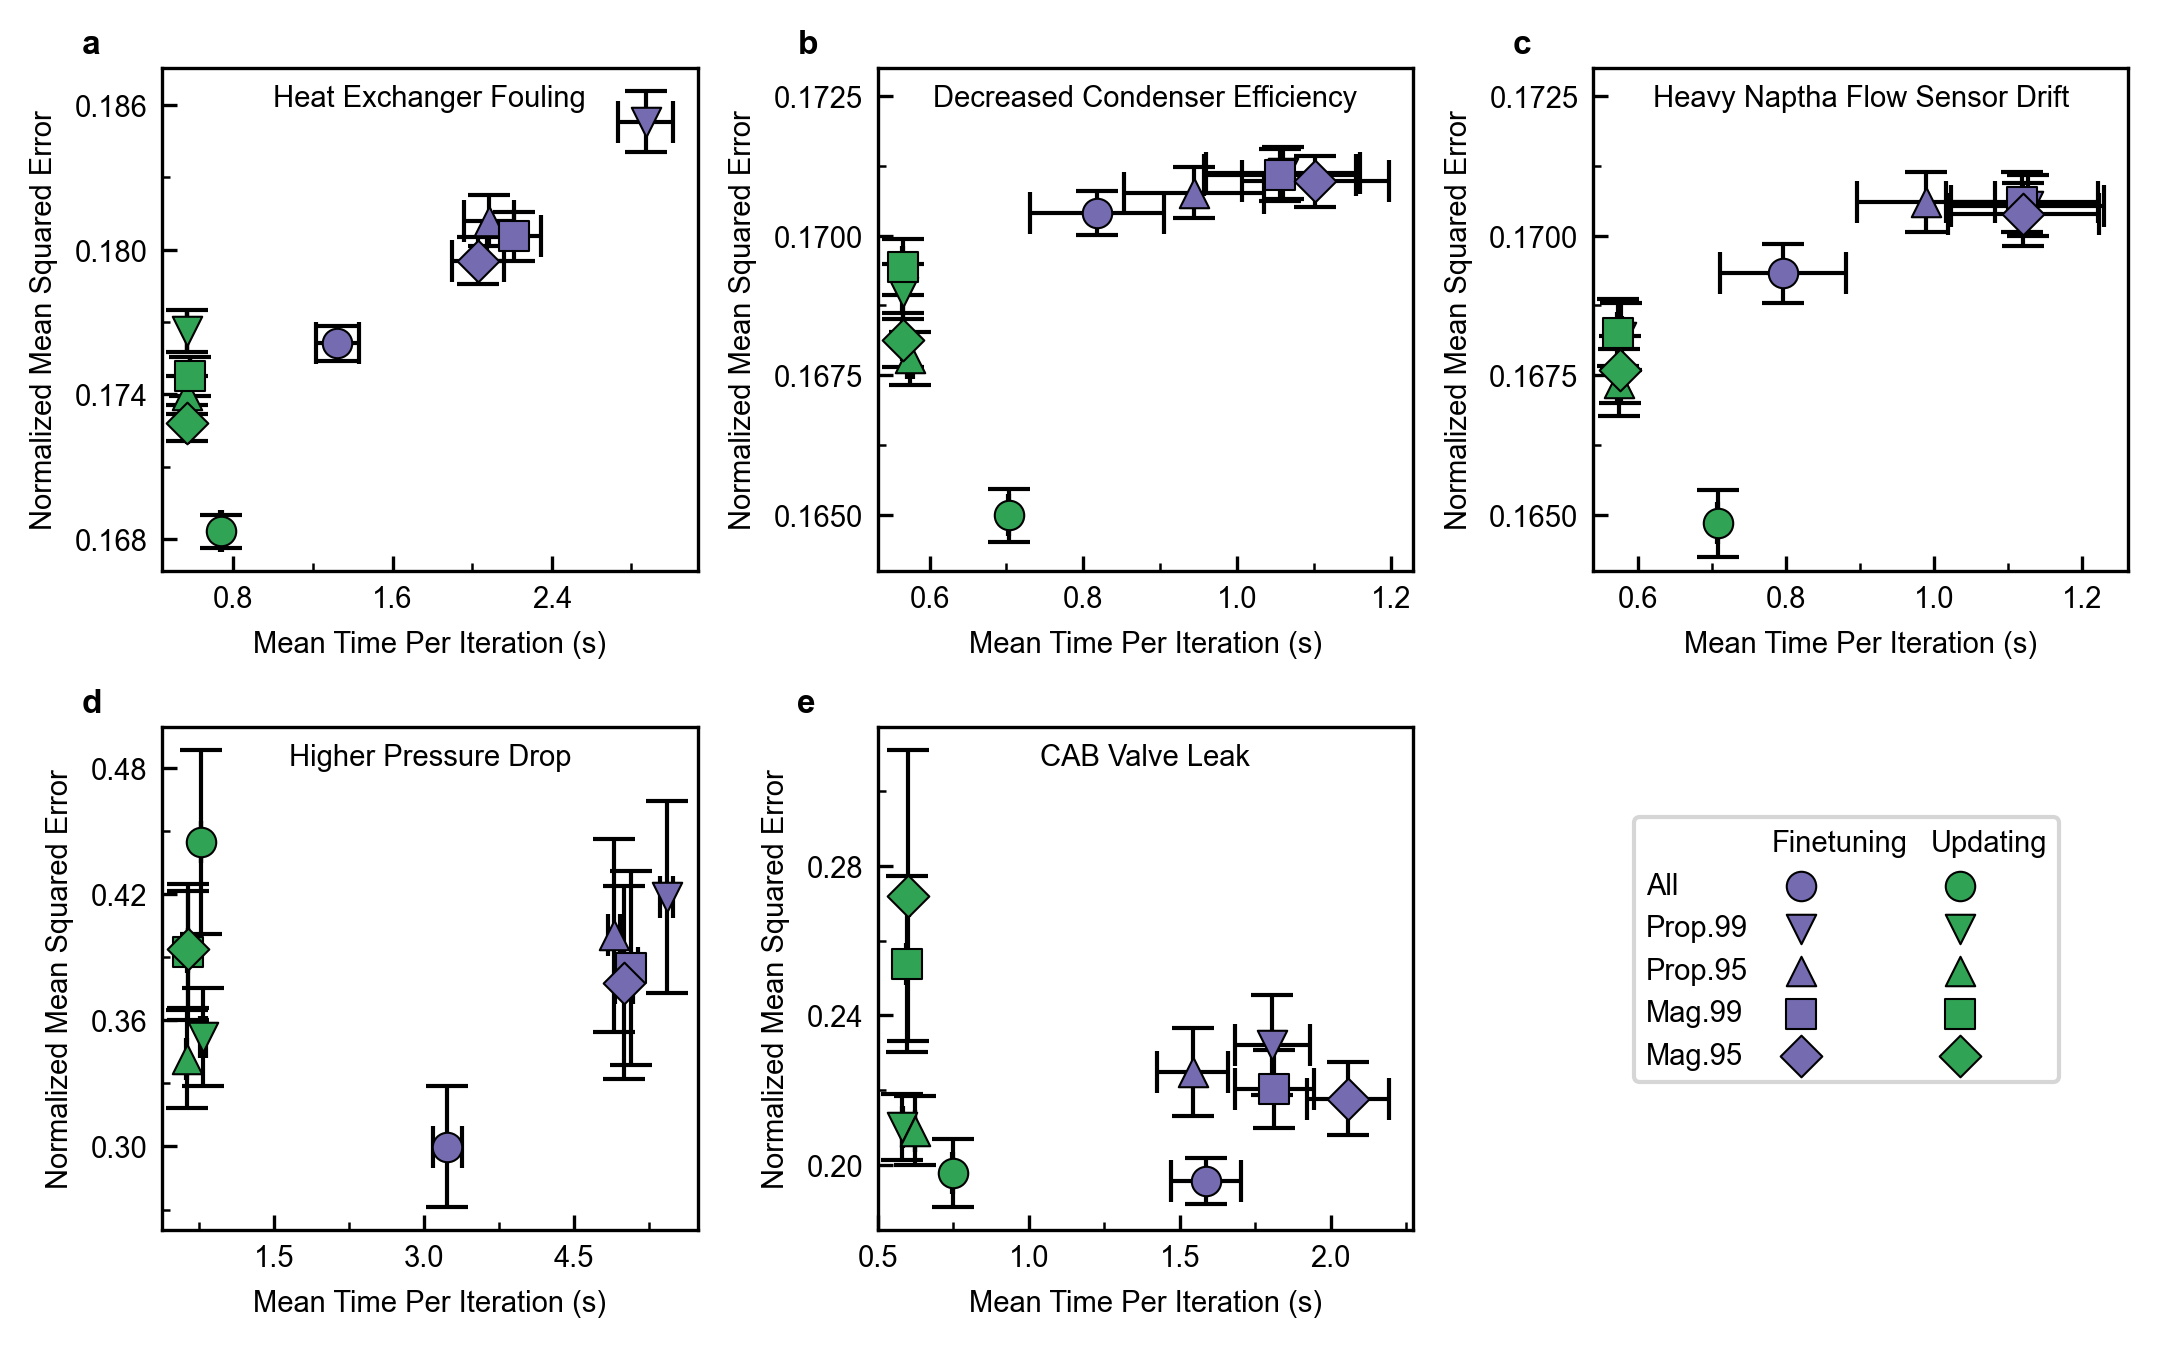

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(183*mm_to_inch, 4.5), dpi=300)
axs = ax.flatten()
for fig_counter, fc in enumerate(FAULTY_CONDITIONS):
    ax = axs[fig_counter]
    ax.set_title(fc, y=1.0, pad=-9)
    
    adam_all_time = np.diff(logger.get_dataset("retraining/"+fc+"/full/time"), axis=0, prepend=0)
    adam_q99_time = np.diff(logger.get_dataset("retraining/"+fc+"/q-0.99/time"), axis=0, prepend=0)
    adam_q95_time = np.diff(logger.get_dataset("retraining/"+fc+"/q-0.95/time"), axis=0, prepend=0)
    adam_t99_time = np.diff(logger.get_dataset("retraining/"+fc+"/t-0.99/time"), axis=0, prepend=0)
    adam_t95_time = np.diff(logger.get_dataset("retraining/"+fc+"/t-0.95/time"), axis=0, prepend=0)
    kf_full_time = np.diff(logger.get_dataset("updating/"+fc+"/full/time"), axis=0, prepend=0)
    kf_q99_time = np.diff(logger.get_dataset("updating/"+fc+"/q-0.99/time"), axis=0, prepend=0)
    kf_q95_time = np.diff(logger.get_dataset("updating/"+fc+"/q-0.95/time"), axis=0, prepend=0)
    kf_t99_time = np.diff(logger.get_dataset("updating/"+fc+"/t-0.99/time"), axis=0, prepend=0)
    kf_t95_time = np.diff(logger.get_dataset("updating/"+fc+"/t-0.95/time"), axis=0, prepend=0)

    adam_all_loss = logger.get_dataset("retraining/"+fc+"/full/loss")
    adam_q99_loss = logger.get_dataset("retraining/"+fc+"/q-0.99/loss")
    adam_q95_loss = logger.get_dataset("retraining/"+fc+"/q-0.95/loss")
    adam_t99_loss = logger.get_dataset("retraining/"+fc+"/t-0.99/loss")
    adam_t95_loss = logger.get_dataset("retraining/"+fc+"/t-0.95/loss")
    kf_full_loss = logger.get_dataset("updating/"+fc+"/full/loss")
    kf_q99_loss = logger.get_dataset("updating/"+fc+"/q-0.99/loss")
    kf_q95_loss = logger.get_dataset("updating/"+fc+"/q-0.95/loss")
    kf_t99_loss = logger.get_dataset("updating/"+fc+"/t-0.99/loss")
    kf_t95_loss = logger.get_dataset("updating/"+fc+"/t-0.95/loss")

    # adam_all = plot_ci(adam_all_loss, adam_all_time, ax, label="All", color=adam_colors[0])
    # adam_p99 = plot_ci(adam_q99_loss, adam_q99_time, ax, label="Quantile 0.99", color=adam_colors[0], marker_fmt="v")
    # adam_p95 = plot_ci(adam_q95_loss, adam_q95_time, ax, label="Quantile 0.95", color=adam_colors[1], marker_fmt="^")
    # adam_m99 = plot_ci(adam_t99_loss, adam_t99_time, ax, label="Threshold 0.99", color=adam_colors[0], marker_fmt="s")
    # adam_m95 = plot_ci(adam_t95_loss, adam_t95_time, ax, label="Threshold 0.95", color=adam_colors[1], marker_fmt="D")
    # sekf_all = plot_ci(kf_full_loss, kf_full_time, ax, label="All", color=kalman_colors[0])
    # sekf_p99 = plot_ci(kf_q99_loss, kf_q99_time, ax, label="Quantile 0.99", color=kalman_colors[0], marker_fmt="v")
    # sekf_p95 = plot_ci(kf_q95_loss, kf_q95_time, ax, label="Quantile 0.95", color=kalman_colors[1], marker_fmt="^")
    # sekf_m99 = plot_ci(kf_t99_loss, kf_t99_time, ax, label="Threshold 0.99", color=kalman_colors[0], marker_fmt="s")
    # sekf_m95 = plot_ci(kf_t95_loss, kf_t95_time, ax, label="Threshold 0.95", color=kalman_colors[1], marker_fmt="D")
    adam_all = plot_ci(adam_all_time, adam_all_loss, ax, label="All", color=adam_colors[0])
    adam_p99 = plot_ci(adam_q99_time, adam_q99_loss, ax, label="Quantile 0.99", color=adam_colors[0], marker_fmt="v")
    adam_p95 = plot_ci(adam_q95_time, adam_q95_loss, ax, label="Quantile 0.95", color=adam_colors[0], marker_fmt="^")
    adam_m99 = plot_ci(adam_t99_time, adam_t99_loss, ax, label="Threshold 0.99", color=adam_colors[0], marker_fmt="s")
    adam_m95 = plot_ci(adam_t95_time, adam_t95_loss, ax, label="Threshold 0.95", color=adam_colors[0], marker_fmt="D")
    sekf_all = plot_ci(kf_full_time, kf_full_loss, ax, label="All", color=kalman_colors[0])
    sekf_p99 = plot_ci(kf_q99_time, kf_q99_loss, ax, label="Quantile 0.99", color=kalman_colors[0], marker_fmt="v")
    sekf_p95 = plot_ci(kf_q95_time, kf_q95_loss, ax, label="Quantile 0.95", color=kalman_colors[0], marker_fmt="^")
    sekf_m99 = plot_ci(kf_t99_time, kf_t99_loss, ax, label="Threshold 0.99", color=kalman_colors[0], marker_fmt="s")
    sekf_m95 = plot_ci(kf_t95_time, kf_t95_loss, ax, label="Threshold 0.95", color=kalman_colors[0], marker_fmt="D")

    # ax.set_xlabel("Mean Squared Error")
    # ax.set_ylabel("Mean Time Per Iteration (s)")
    ax.xaxis.set_major_locator(MaxNLocator(4))
    ax.yaxis.set_major_locator(MaxNLocator(4))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    
    ax.set_xlabel("Mean Time Per Iteration (s)")
    ax.set_ylabel("Normalized Mean Squared Error")
    
    if fig_counter == 1:
        ax.set_ybound(0.164, 0.173)
    elif fig_counter == 2:
        ax.set_ybound(0.164, 0.173)

# set axes equal
if False:
    ylim = [0,0]
    xlim = [0,0]
    for a in axs[:-1]:
        ylim[0] = min(ylim[0], a.get_ylim()[0])
        ylim[1] = max(ylim[1], a.get_ylim()[1])
        xlim[0] = min(xlim[0], a.get_xlim()[0])
        xlim[1] = max(xlim[1], a.get_xlim()[1])
    for a in axs[:-1]:
        a.set_ylim(ylim)
        a.set_xlim(xlim)

# Axis labels
# fig.text(0.5, 0.02, "Mean Squared Error", ha='center', va="top")
# fig.text(0.02, 0.5, "Mean Time Per Iteration (s)", va='center', ha="right", rotation='vertical')
# fig.text(0.5, -0.00, "Mean Time Per Iteration (s)", ha='center', va="top", fontsize=7)
# fig.text(-0.00, 0.5, "Normalized Mean Squared Error", va='center', ha="right", rotation='vertical', fontsize=7)

# legend
ax = axs[-1]
ax.axis("off")

legend_handle, legend_labels, ncol = table_legend(
    np.array([
        [adam_all, sekf_all],
        [adam_p99, sekf_p99],
        [adam_p95, sekf_p95],
        [adam_m99, sekf_m99],
        [adam_m95, sekf_m95]
    ]),
    row_labels=["All", selection_methods["quantile_abbrev"]+"99", selection_methods["quantile_abbrev"]+"95", selection_methods["threshold_abbrev"]+"99", selection_methods["threshold_abbrev"]+"95"],
    column_labels=["Finetuning", "Updating"]

)

axs[-1].legend(legend_handle, legend_labels, columnspacing=0.8,
    ncol = ncol, shadow = False, handletextpad = -2,
    bbox_to_anchor = (0.05, 0.85),  loc = "upper left")

# fig.subplots_adjust(wspace=0.25)
# fig.tight_layout()
annotation_xy = (-0.15, 1.03)
annotation_fontsize = 8
axs[0].annotate("a", xy=annotation_xy, xycoords="axes fraction", fontsize=annotation_fontsize, fontweight="bold")
axs[1].annotate("b", xy=annotation_xy, xycoords="axes fraction", fontsize=annotation_fontsize, fontweight="bold")
axs[2].annotate("c", xy=annotation_xy, xycoords="axes fraction", fontsize=annotation_fontsize, fontweight="bold")
axs[3].annotate("d", xy=annotation_xy, xycoords="axes fraction", fontsize=annotation_fontsize, fontweight="bold")
axs[4].annotate("e", xy=annotation_xy, xycoords="axes fraction", fontsize=annotation_fontsize, fontweight="bold")

fig.tight_layout()
# fig.savefig(os.path.join(results_dir, f"fcc_multiplot_mse_time_scatter.pdf"), bbox_inches='tight')
# fig.savefig(os.path.join(results_dir, f"fcc_multiplot_mse_time_scatter_uniform_scale.pdf"), bbox_inches='tight')
fig.savefig(os.path.join(report_dir, "fcc_scatterplot.eps"))

# final_figure_size = plt.gcf().get_size_inches()
# print(f"Final figure size: {final_figure_size}")
plt.show()

## Blood Glucose

In [111]:
from utils.glucose import GlucoseDataset
from utils.glucose import get_glucose_data

results_dir = os.path.join("results", "glucose")
logger = h5_logger(os.path.join(results_dir, "data.h5"))

step_size = 10

data = get_glucose_data(logger, "training/data")
Xscaler = skp.StandardScaler()
Uscaler = skp.StandardScaler()
train_dataset = GlucoseDataset(data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=step_size,
    databounds=[0, 0.8],
    train=True,
    Xscaler=Xscaler,
    Uscaler=Uscaler
)
val_dataset = GlucoseDataset(data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=step_size,
    databounds=[0.8, 0.9],
    Xscaler=Xscaler,
    Uscaler=Uscaler
)
test_dataset = GlucoseDataset(data,
    prediction_horizon=60,
    input_horizon=1,
    step_size=step_size,
    databounds=[0.9, 1],
    Xscaler=Xscaler,
    Uscaler=Uscaler
)                        

model = torch.load(os.path.join(results_dir, "model.pth"), weights_only=False)
# model = torch.load(os.path.join(results_dir, "model.pt"))
n_model_parameters = get_parameter_vector(model).shape[0]
n_inputs = 6 + 2*60
n_outputs = 6 * 60
size_jacobian = n_outputs * n_model_parameters
print(f"Number of model parameters: {n_model_parameters:3,d}")
print(f"Number of inputs: {n_inputs}")
print(f"Number of outputs: {n_outputs}")
print(f"Size of Jacobian: {size_jacobian:3,d}")

Number of model parameters: 1,574
Number of inputs: 126
Number of outputs: 360
Size of Jacobian: 566,640


In [115]:
table

NameError: name 'table' is not defined

In [116]:
default = {
    "method": "-",
    "parameters": "-",
    "Loss": "-",
    "Loss 95\% CI": "-",
    "FSS": "-",
    "FSS 95\% CI": "-",
    "Time": "-",
    "Time 95\% CI": "-",
}

maintenance_methods = ["retraining", "updating"] # "control"
parameter_selection_methods = ["full", "q-0.95", "q-0.99", "t-0.95", "t-0.99"]

# table 
table_rows = []
training_data = default.copy()
training_data["method"] = "Training"
training_data["Loss"], training_data["Loss 95\% CI"] = get_ci(logger.get_dataset("training/data w noise/model performance/train/loss")[:,0])
table_rows.append(training_data)
validation_data = default.copy()
validation_data["method"] = "Validation"
validation_data["Loss"], validation_data["Loss 95\% CI"] = get_ci(logger.get_dataset("training/data w noise/model performance/val/loss")[:,0])
table_rows.append(validation_data)
test_data = default.copy()
test_data["method"] = "Test"
test_data["Loss"], test_data["Loss 95\% CI"] = get_ci(logger.get_dataset("training/data w noise/model performance/test/loss")[:,0])
table_rows.append(test_data)
# control predictions
control_data = default.copy()
control_predictions = logger.get_dataset("drifting si/control/xp_scaled")
dataset_predictions = logger.get_dataset("drifting si/dataset/x_scaled")
control_loss = ((control_predictions - dataset_predictions)**2).mean(axis=-1).mean(axis=-1)
control_data["method"] = "No Maintenance"
control_data["Loss"], control_data["Loss 95\% CI"] = get_ci(control_loss)
table_rows.append(control_data)



for mm in maintenance_methods:
    for psm in parameter_selection_methods:
        row_data = default.copy()
        row_data["method"] = mm
        row_data["parameters"] = psm
        row_data["Loss"], row_data["Loss 95\% CI"] = get_ci(logger.get_dataset(f"drifting si/{mm}/{psm}/loss"))
        # 
        row_data["FSS"] = 1 - row_data["Loss"] / control_loss.mean()
        _, row_data["FSS 95\% CI"] = get_ci(1-np.divide(logger.get_dataset(f"drifting si/{mm}/{psm}/loss"),control_loss))
        row_data["Time"], row_data["Time 95\% CI"] = get_ci(np.diff(logger.get_dataset(f"drifting si/{mm}/{psm}/time")[:,0], prepend=0, axis=0))
        table_rows.append(row_data)
        
df = pd.DataFrame(table_rows)
df.to_latex(os.path.join(results_dir, "glucose_table.tex"), index=False, float_format="%.4e")
                                                            


combined example day, control schematic

KeyError: 'Unable to open object (component not found)'

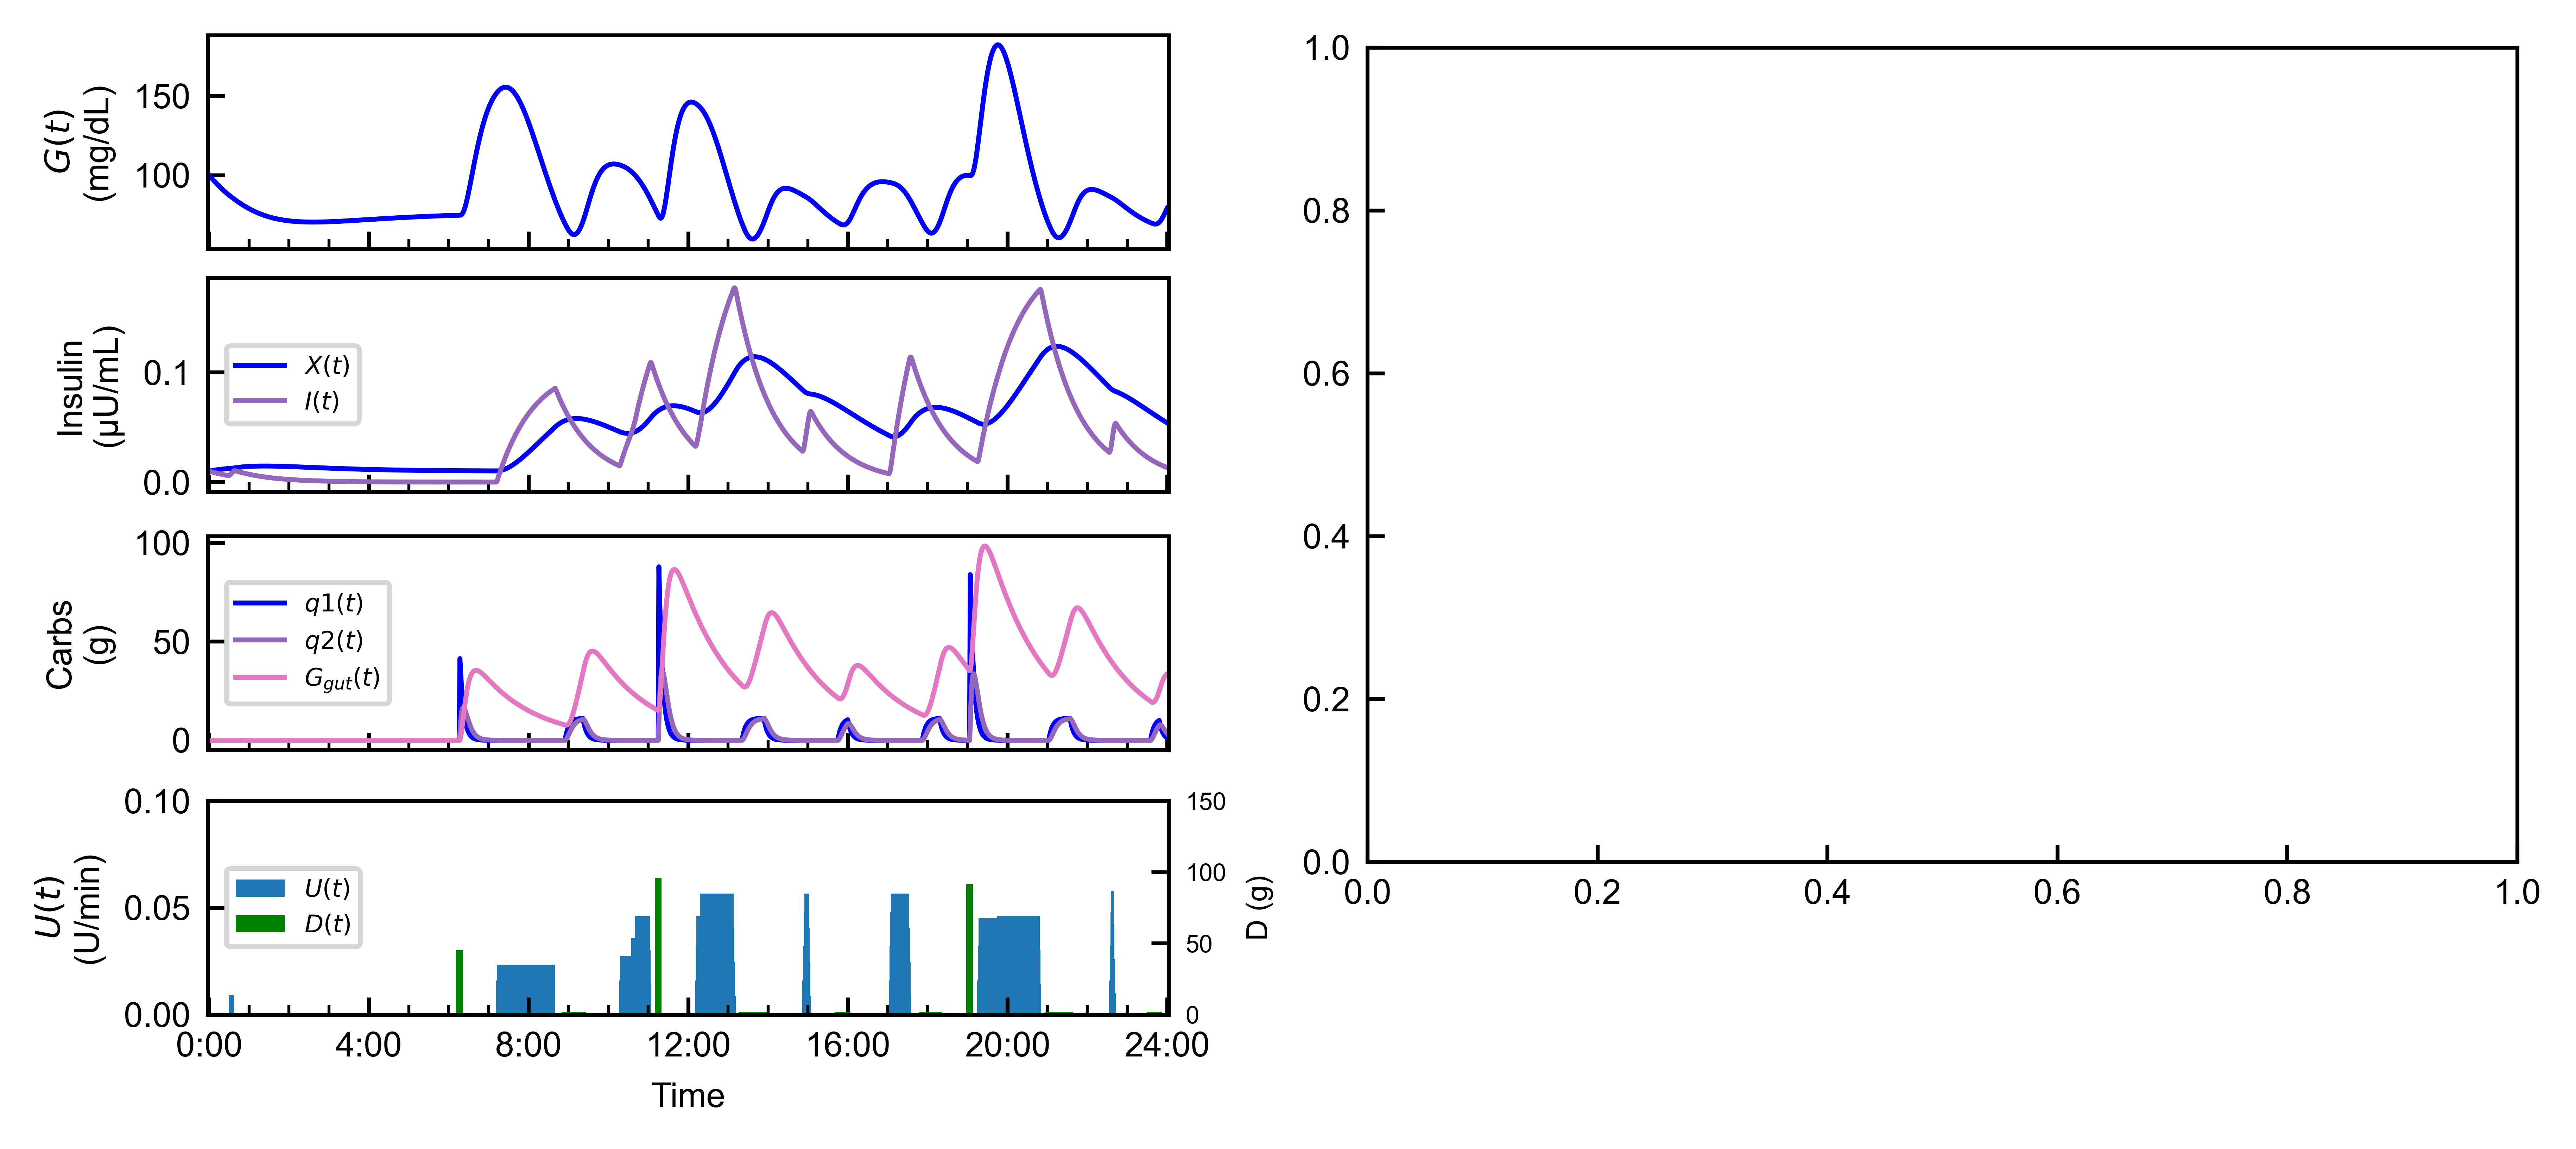

In [117]:
# set up figures
fig = plt.figure(figsize=(183*mm_to_inch, 80*mm_to_inch), dpi=1000)

subfigures_gridspec = mpl.gridspec.GridSpec(1, 2, figure=fig, hspace=0.2, wspace=0.25)
ax1_gridspec = subfigures_gridspec[0,0].subgridspec(4, 1, hspace=0.05)
ax10 = fig.add_subplot(ax1_gridspec[0,:])
ax11 = fig.add_subplot(ax1_gridspec[1,:])
ax12 = fig.add_subplot(ax1_gridspec[2,:])
ax13 = fig.add_subplot(ax1_gridspec[3,:])
ax1 = [ax10, ax11, ax12, ax13]
ax2_gridspec = subfigures_gridspec[0,1].subgridspec(5,1)
ax2 = fig.add_subplot(ax2_gridspec[:-1,:])

##### figure 1: example day #####
day_index = 0
# ---
ax=ax1
dataset_idx = np.arange(1440*day_index, 1440*(day_index+1)+1)

# dataset #
G = logger.get_dataset("training/data/G")[0, dataset_idx]
I = logger.get_dataset("training/data/I")[0, dataset_idx]
X = logger.get_dataset("training/data/X")[0, dataset_idx]
Q1 = logger.get_dataset("training/data/Q1")[0, dataset_idx]
Q2 = logger.get_dataset("training/data/Q2")[0, dataset_idx]
G_gut = logger.get_dataset("training/data/G_gut")[0, dataset_idx]
U = logger.get_dataset("training/data/U")[0, dataset_idx]
D = logger.get_dataset("training/data/D")[0, dataset_idx]

t = np.linspace(0, 24, 1441)
true_kwargs = dict(c='b')
pred_kwargs = dict(c='r', linestyle='dashed')
u0_kwargs = dict(c='g', label='CV')
u1_kwargs = dict(c='m', label='Bolus')
bar_width = 1/60
multipliers = np.array([0,1], dtype=int)

with plt.rc_context({'lines.linewidth': 1,
    "axes.labelsize": 6,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "legend.fontsize": 5,
    "legend.borderaxespad": 0.75,
    "legend.loc": "center left"}):
    # G
    true_line = ax[0].plot(t, G, **true_kwargs)
    ax[0].set_ylabel(r'$G(t)$'+'\n(mg/dL)')
    # IX  # TODO: label each line
    ax1_X = ax[1].plot(t, X, label=r"$X(t)$", **true_kwargs)
    ax1_I = ax[1].plot(t, I, label=r"$I(t)$", c="tab:purple")
    ax[1].set_ylabel('Insulin\n(μU/mL)')
    ax[1].legend()
    # Q1, Q2, G_gut  TODO: label each line
    ax[2].plot(t, Q1, label=r"$q1(t)$", **true_kwargs)
    ax[2].plot(t, Q2, label=r"$q2(t)$", c="tab:purple")
    ax[2].plot(t, G_gut, label=r"$G_{gut}(t)$", c="tab:pink")
    ax[2].set_ylabel('Carbs\n(g)')
    ax[2].legend()
    # ax[2].set_ylim(ax[2].get_ylim()[0]-5, ax[2].get_ylim()[1]+5)
    # ax[2].yaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
    # ax[2].yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: int(x)))
    # ax[2].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
    # U[0]: Insulin infusion
    # ax[3].step(t-1, u[idx, :, 0], where="post", **u0_kwargs)
    u_marker = ax[3].bar(t, U, width=bar_width, color="tab:blue", label=r"$U(t)$")
    ax[3].set_ylabel(r'$U(t)$'+'\n(U/min)')
    ax[3].set_ylim(0, 0.1)
    # ax[3].yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.02))
    # D[0]: Meal disturbance
    # ax3 = ax[2].twinx()
    ax13 = ax[3].twinx()
    d_marker = ax13.bar(t-1/60+bar_width, D, width=bar_width*10, color="g", label=r"$D(t)$")
    ax13.set_ylim(0, 150)
    ax13.set_ylabel('D (g)')
    ax[3].legend([u_marker, d_marker], [r"$U(t)$", r"$D(t)$"])

    # twinx config 
    for i in range(4):
        ax[i].set_xlim(0-2/60, 24+2/60)
        ax[i].xaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
        ax[i].xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
        ax[i].xaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, _: f"{int(x)}:00"))
    for i in range(3):
        # remove tick labels
        ax[i].set_xticklabels([])
    ax[3].set_xlabel('Time')
    
##### Figure 2: Control/Distributions #####
ax = ax2
raw_logger = h5_logger(os.path.join(results_dir, "raw_data.h5"))
G_no_control = raw_logger.get_dataset("training/data/G")[0]
G_constant = logger.get_dataset("training/data w noise/G")[0]
G_drifting = logger.get_dataset("drifting si/data/G")[0]

ax22 = ax.twinx()

# fill_patch = ax22.fill_between([70, 135], 0, 1, color="lightgray", label="Healthy Glucose Range", zorder=0)
fill_patch = ax.fill_between([70, 135], 0, 0.071, color="lightgray", label="Healthy Glucose Range", zorder=0)

kde_kwargs = {"ax":ax,
    "bw_adjust": 0.5,
    "zorder": 3}
sns.kdeplot(G_no_control, label="No Control", **kde_kwargs)
sns.kdeplot(G_constant, label="Constant Control", **kde_kwargs)
sns.kdeplot(G_drifting, label="Drifting Control", **kde_kwargs)

ecdf_kwargs = {"ax":ax22,
    "linestyle": ":",
    "zorder": 1}
sns.ecdfplot(G_no_control, label="No Control", **ecdf_kwargs)
sns.ecdfplot(G_constant, label="Constant Control", **ecdf_kwargs)
sns.ecdfplot(G_drifting, label="Drifting Control", **ecdf_kwargs)

ax22.vlines([70, 85], 0, 1, color="black", linestyle="-", linewidth=0.5)

arrow1_height = 0.55
arrow2_height = 0.85
ax22.annotate("Begin Taking\nGlucose\nSupplement", (69, arrow1_height+0.02), ha="right", va="bottom", fontsize=5)
ax22.annotate("", (60, arrow1_height), (71.5, arrow1_height), arrowprops=dict(arrowstyle="->", color="black"), ha="left")
ax22.annotate("Stop Insulin\nInjections", (86, arrow2_height+0.02), ha="left", va="bottom", fontsize=5)
ax22.annotate("", (75, arrow2_height), (86.5, arrow2_height), arrowprops=dict(arrowstyle="->", color="black"), ha="left")

ax.set_xlim(0, 250)
ax.set_ylim(0, 0.071)
ax22.set_ylim(0, 1)
ax.set_xlabel("Blood Glucose Concentration (mg/dL)")
ax.spines["right"].set_linestyle(":")
ax22.spines["right"].set_linestyle(":")
ax22.set_ylabel("Cumulative Density")

line_colors = sns.color_palette()[:3]
legend_lines = [(plt.plot([], [], color=c)[0], plt.plot([], [], color=c, linestyle=":")[0]) for c in line_colors] + [fill_patch]
legend_labels = ["No Control", r"Constant $s_i$", r"Drifting $s_i$", "Healthy Glucose Range"]
legend_lines = [plt.plot([], [], color="k")[0], plt.plot([], [], color="k", linestyle=":")[0]] + legend_lines
legend_labels = ["Density", "Cumulative Density"] + legend_labels
ax.legend(handles=legend_lines,labels=legend_labels, 
    loc="upper right", bbox_to_anchor=(0.99, -0.13), ncol=2, columnspacing=1.5,
    handler_map={tuple: mpl.legend_handler.HandlerTuple(ndivide=None)})

# subplot labels
subplot_label_axes = [ax10, ax2]
labelstring = "abcdefg"
label_xpad = 0.02
labelypad = 0.01
for i, ax in enumerate(subplot_label_axes):
    box = ax.get_position()
    minx = min(box.x0, box.x1)
    maxy = max(box.y0, box.y1)
    fig.text(minx-label_xpad, maxy+labelypad, f"{labelstring[i]}", fontsize=8, fontweight="bold")

fig.savefig(os.path.join(report_dir, "glucose_methods.eps"))
plt.show()

## combined plots

combined CSTR/Glucose scatterplots

(np.float64(7.2047244094488185), np.float64(3.0))

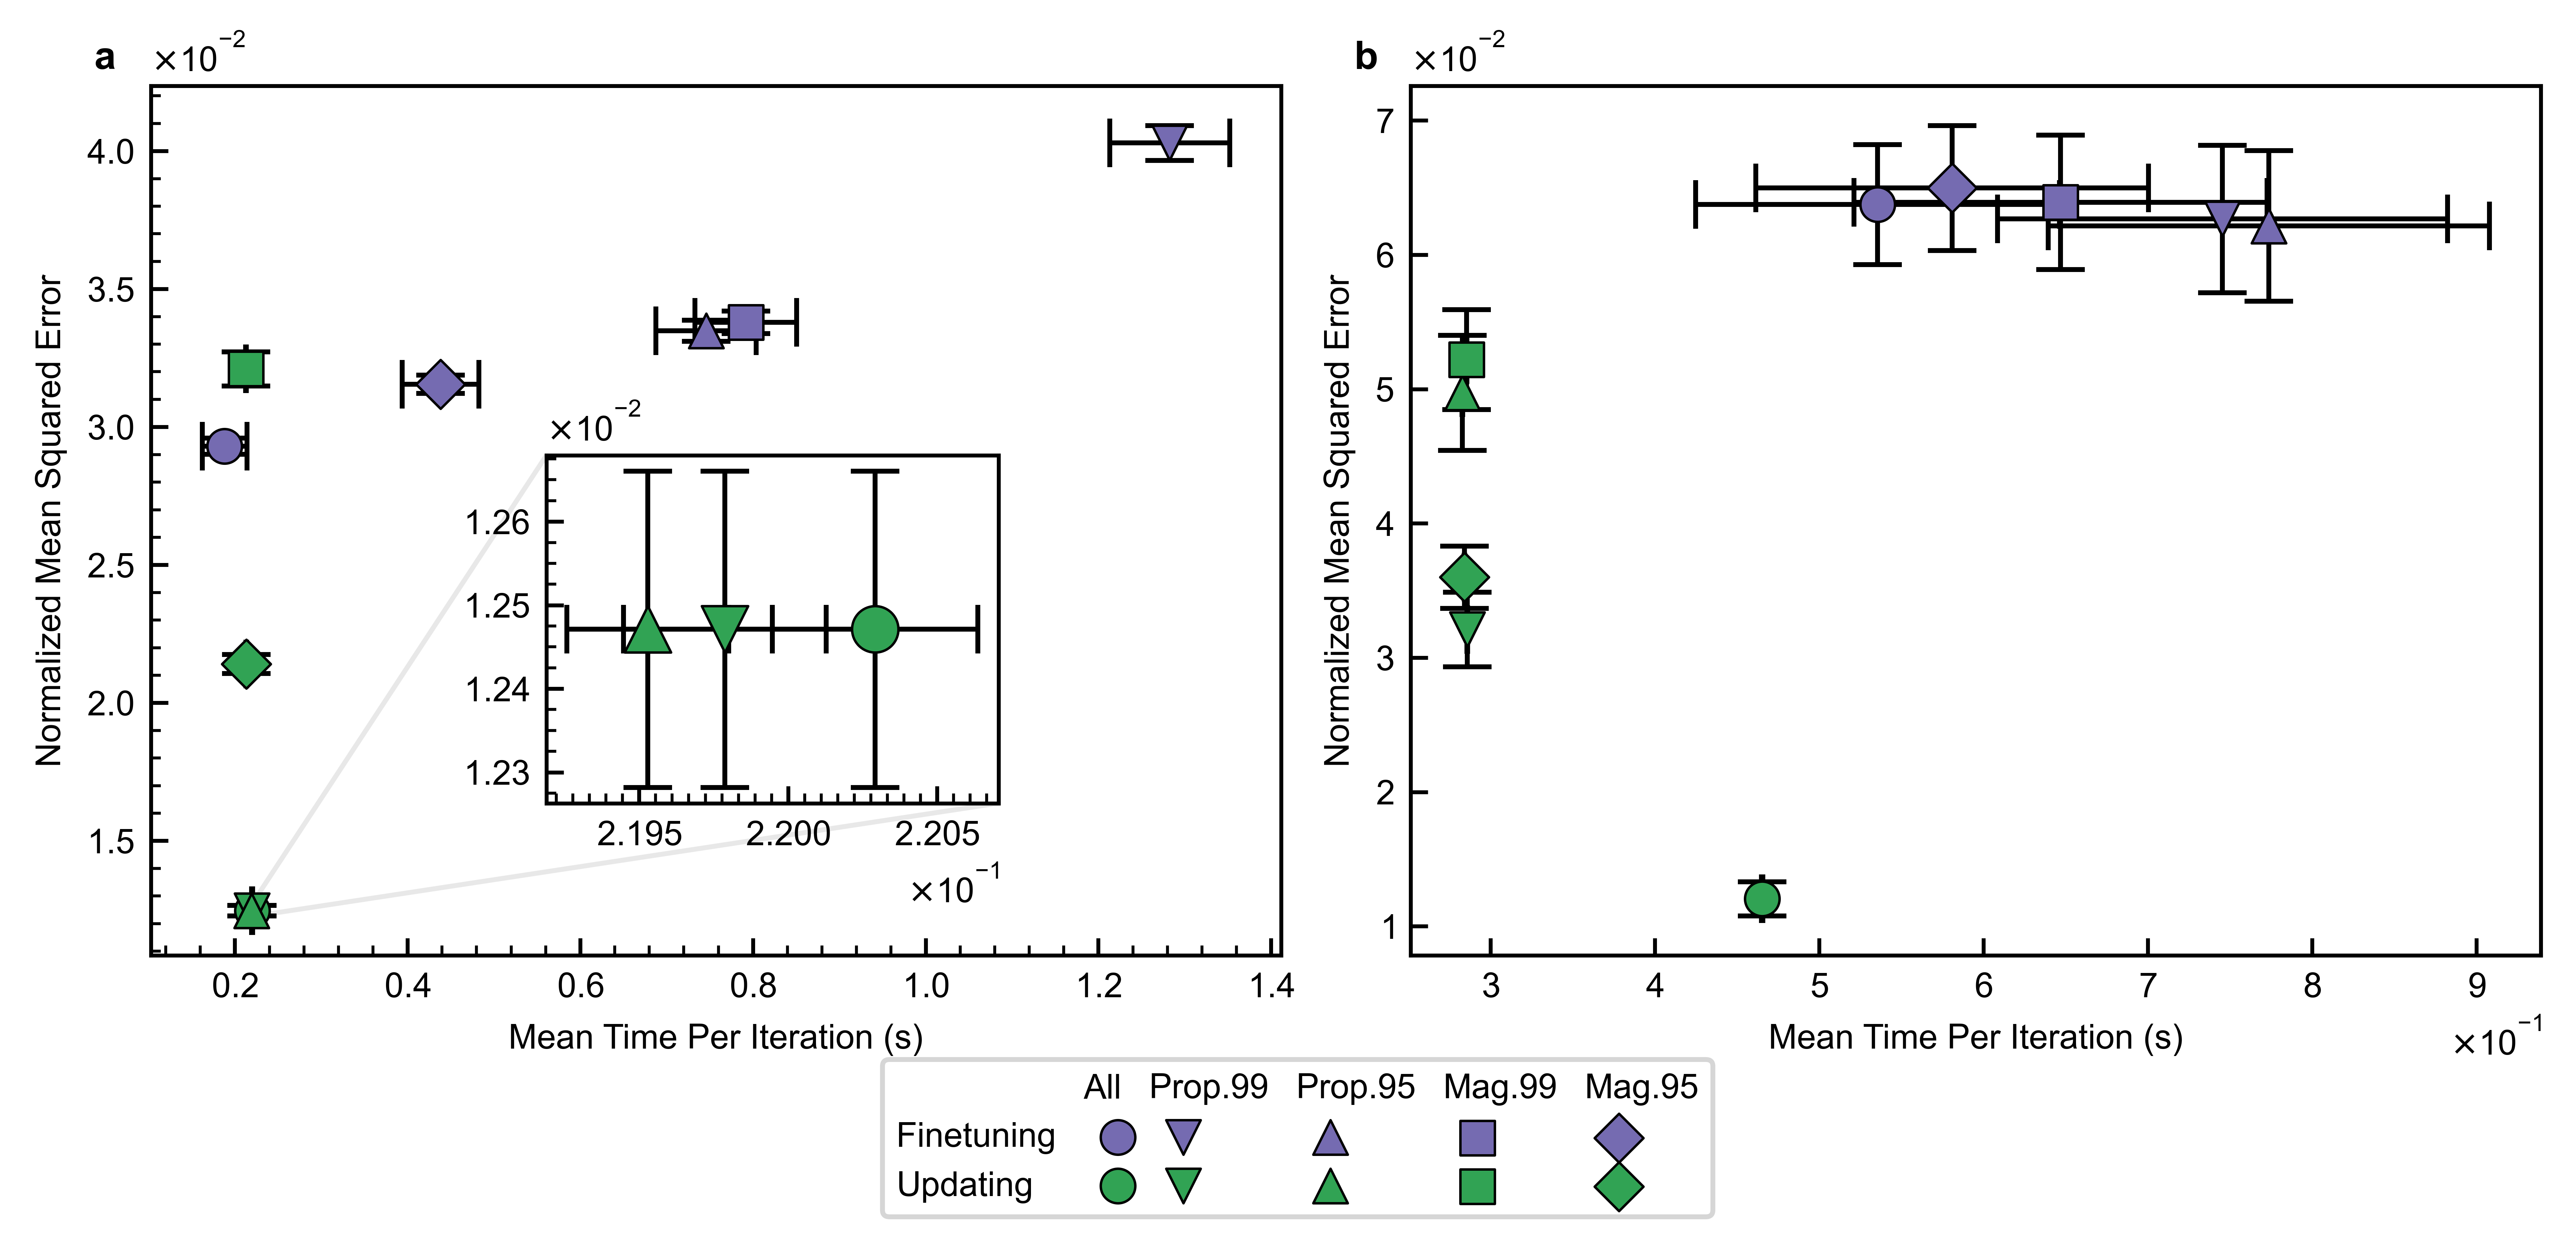

In [130]:
# combined CSTR and glucose scatterplots
fig, axes = plt.subplots(1, 2, figsize=(183*mm_to_inch, 3), dpi=1000)
axs = axes.flatten()
ax = axs[0]

logger = h5_logger(os.path.join("results", "CSTR", "data.h5"))

# times are cumulative so take the difference
control_loss = logger.get_dataset("updating/control/loss")
adam_all_loss = logger.get_dataset("updating/adam-all/0.001/loss")
adam_all_time = np.diff(logger.get_dataset("updating/adam-all/0.001/time"),axis=0, prepend=0)
adam_q99_loss = logger.get_dataset("updating/adam-quantile-0.99/0.001/loss")
adam_q99_time = np.diff(logger.get_dataset("updating/adam-quantile-0.99/0.001/time"),axis=0, prepend=0)
adam_q95_loss = logger.get_dataset("updating/adam-quantile-0.95/0.001/loss")
adam_q95_time = np.diff(logger.get_dataset("updating/adam-quantile-0.95/0.001/time"),axis=0, prepend=0)
adam_t99_loss = logger.get_dataset("updating/adam-thresh-0.99/0.001/loss")
adam_t99_time = np.diff(logger.get_dataset("updating/adam-thresh-0.99/0.001/time"),axis=0, prepend=0)
adam_t95_loss = logger.get_dataset("updating/adam-thresh-0.95/0.001/loss")
adam_t95_time = np.diff(logger.get_dataset("updating/adam-thresh-0.95/0.001/time"),axis=0, prepend=0)
kf_all_loss = logger.get_dataset("updating/kf-all/0.0003/loss")
kf_all_time = np.diff(logger.get_dataset("updating/kf-all/0.0003/time"),axis=0, prepend=0)
kf_q99_loss = logger.get_dataset("updating/kf-quantile-0.99/0.0003/loss")
kf_q99_time = np.diff(logger.get_dataset("updating/kf-quantile-0.99/0.0003/time"),axis=0, prepend=0)
kf_q95_loss = logger.get_dataset("updating/kf-quantile-0.95/0.0003/loss")
kf_q95_time = np.diff(logger.get_dataset("updating/kf-quantile-0.95/0.0003/time"),axis=0, prepend=0)
kf_t99_loss = logger.get_dataset("updating/kf-thresh-0.99/0.0003/loss")
kf_t99_time = np.diff(logger.get_dataset("updating/kf-thresh-0.99/0.0003/time"),axis=0, prepend=0)
kf_t95_loss = logger.get_dataset("updating/kf-thresh-0.95/0.0003/loss")
kf_t95_time = np.diff(logger.get_dataset("updating/kf-thresh-0.95/0.0003/time"),axis=0, prepend=0)

# fig, ax = plt.subplots(figsize=(89*mm_to_inch, 2.5), dpi=1000)
# adam_all = plot_ci(adam_all_loss, adam_all_time, ax=ax, color=adam_colors[0], label="Retraining (All)")
# adam_p99 = plot_ci(adam_q99_loss, adam_q99_time, ax=ax, color=adam_colors[1], label="Retraining (Quant. 0.99)", marker_fmt="^")
# adam_p95 = plot_ci(adam_q95_loss, adam_q95_time, ax=ax, color=adam_colors[2], label="Retraining (Quant. 0.95)", marker_fmt="v")
# adam_m99 = plot_ci(adam_t99_loss, adam_t99_time, ax=ax, color=adam_colors[1], label="Retraining (Thresh. 0.99)", marker_fmt="s")
# adam_m95 = plot_ci(adam_t95_loss, adam_t95_time, ax=ax, color=adam_colors[2], label="Retraining (Thresh. 0.95)", marker_fmt="D")
# # sekf_all = plot_ci(kf_all_loss, kf_all_time, ax=ax, color="none", label="95% Confidence Bounds", marker_fmt="")
# # ax.errorbar(np.nan, np.nan, yerr=np.nan, color="none", label=" ")
# sekf_all = plot_ci(kf_all_loss, kf_all_time, ax=ax, color=kalman_colors[0], label="Kalman (All)")
# sekf_p99 = plot_ci(kf_q99_loss, kf_q99_time, ax=ax, color=kalman_colors[1], label="Kalman (Quant. 0.99)", marker_fmt="v")
# sekf_p95 = plot_ci(kf_q95_loss, kf_q95_time, ax=ax, color=kalman_colors[2], label="Kalman (Quant. 0.95)", marker_fmt="^")
# sekf_m99 = plot_ci(kf_t99_loss, kf_t99_time, ax=ax, color=kalman_colors[1], label="Kalman (Thresh. 0.99)", marker_fmt="s")
# sekf_m95 = plot_ci(kf_t95_loss, kf_t95_time, ax=ax, color=kalman_colors[2], label="Kalman (Thresh. 0.95)", marker_fmt="D")
adam_all = plot_ci(adam_all_time, adam_all_loss, ax=ax, color=adam_colors[0], label="Retraining (All)")
adam_p99 = plot_ci(adam_q99_time, adam_q99_loss, ax=ax, color=adam_colors[0], label="Retraining (Quant. 0.99)", marker_fmt="v")
adam_p95 = plot_ci(adam_q95_time, adam_q95_loss, ax=ax, color=adam_colors[0], label="Retraining (Quant. 0.95)", marker_fmt="^")
adam_m99 = plot_ci(adam_t99_time, adam_t99_loss, ax=ax, color=adam_colors[0], label="Retraining (Thresh. 0.99)", marker_fmt="s")
adam_m95 = plot_ci(adam_t95_time, adam_t95_loss, ax=ax, color=adam_colors[0], label="Retraining (Thresh. 0.95)", marker_fmt="D")
sekf_all = plot_ci(kf_all_time, kf_all_loss, ax=ax, color=kalman_colors[0], label="Kalman (All)")
sekf_p99 = plot_ci(kf_q99_time, kf_q99_loss, ax=ax, color=kalman_colors[0], label="Kalman (Quant. 0.99)", marker_fmt="v")
sekf_p95 = plot_ci(kf_q95_time, kf_q95_loss, ax=ax, color=kalman_colors[0], label="Kalman (Quant. 0.95)", marker_fmt="^")
sekf_m99 = plot_ci(kf_t99_time, kf_t99_loss, ax=ax, color=kalman_colors[0], label="Kalman (Thresh. 0.99)", marker_fmt="s")
sekf_m95 = plot_ci(kf_t95_time, kf_t95_loss, ax=ax, color=kalman_colors[0], label="Kalman (Thresh. 0.95)", marker_fmt="D")

# inset
inset_marker_size = 90
axins = ax.inset_axes([0.35, 0.175, 0.4, 0.4])
plot_ci(kf_all_time, kf_all_loss, ax=axins, color=kalman_colors[0], marker_size=inset_marker_size)
plot_ci(kf_q99_time, kf_q99_loss, ax=axins, color=kalman_colors[0], marker_fmt="v", marker_size=inset_marker_size)
plot_ci(kf_q95_time, kf_q95_loss, ax=axins, color=kalman_colors[0], marker_fmt="^", marker_size=inset_marker_size)

ax.indicate_inset_zoom(axins, edgecolor="lightgrey", zorder=0)

ax.set_ylabel("Normalized Mean Squared Error")
ax.set_xlabel("Mean Time Per Iteration (s)")
ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(5))
ax.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)
axins.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(4))
axins.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(9))
axins.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)


# glucose
logger = h5_logger(os.path.join("results", "glucose", "data.h5"))
ax = axs[1]

retraining_full_loss = logger.get_dataset("drifting si/retraining/full/loss")
retraining_full_time = np.diff(logger.get_dataset("drifting si/retraining/full/time"), prepend=0, axis=0)
retraining_q95_loss = logger.get_dataset("drifting si/retraining/q-0.95/loss")
retraining_q95_time = np.diff(logger.get_dataset("drifting si/retraining/q-0.95/time"), prepend=0, axis=0)
retraining_q99_loss = logger.get_dataset("drifting si/retraining/q-0.99/loss")
retraining_q99_time = np.diff(logger.get_dataset("drifting si/retraining/q-0.99/time"), prepend=0, axis=0)
retraining_m95_loss = logger.get_dataset("drifting si/retraining/t-0.95/loss")
retraining_m95_time = np.diff(logger.get_dataset("drifting si/retraining/t-0.95/time"), prepend=0, axis=0)
retraining_m99_loss = logger.get_dataset("drifting si/retraining/t-0.99/loss")
retraining_m99_time = np.diff(logger.get_dataset("drifting si/retraining/t-0.99/time"), prepend=0, axis=0)
updating_full_loss = logger.get_dataset("drifting si/updating/full/loss")
updating_full_time = np.diff(logger.get_dataset("drifting si/updating/full/time"), prepend=0, axis=0)
updating_q95_loss = logger.get_dataset("drifting si/updating/q-0.95/loss")
updating_q95_time = np.diff(logger.get_dataset("drifting si/updating/q-0.95/time"), prepend=0, axis=0)
updating_q99_loss = logger.get_dataset("drifting si/updating/q-0.99/loss")
updating_q99_time = np.diff(logger.get_dataset("drifting si/updating/q-0.99/time"), prepend=0, axis=0)
updating_m95_loss = logger.get_dataset("drifting si/updating/t-0.95/loss")
updating_m95_time = np.diff(logger.get_dataset("drifting si/updating/t-0.95/time"), prepend=0, axis=0)
updating_m99_loss = logger.get_dataset("drifting si/updating/t-0.99/loss")
updating_m99_time = np.diff(logger.get_dataset("drifting si/updating/t-0.99/time"), prepend=0, axis=0)

retraining_full = plot_ci(retraining_full_time, retraining_full_loss, ax, color=adam_colors[0])
retraining_q95 = plot_ci(retraining_q95_time, retraining_q95_loss, ax, color=adam_colors[0], marker_fmt="v")
retraining_q99 = plot_ci(retraining_q99_time, retraining_q99_loss, ax, color=adam_colors[0], marker_fmt="^")
retraining_m95 = plot_ci(retraining_m95_time, retraining_m95_loss, ax, color=adam_colors[0], marker_fmt="D")
retraining_m99 = plot_ci(retraining_m99_time, retraining_m99_loss, ax, color=adam_colors[0], marker_fmt="s")
updating_full = plot_ci(updating_full_time, updating_full_loss, ax, color=kalman_colors[0])
updating_q95 = plot_ci(updating_q95_time, updating_q95_loss, ax, color=kalman_colors[0], marker_fmt="v")
updating_q99 = plot_ci(updating_q99_time, updating_q99_loss, ax, color=kalman_colors[0], marker_fmt="^")
updating_m95 = plot_ci(updating_m95_time, updating_m95_loss, ax, color=kalman_colors[0], marker_fmt="D")
updating_m99 = plot_ci(updating_m99_time, updating_m99_loss, ax, color=kalman_colors[0], marker_fmt="s")

legend_handle, legend_labels, ncol = table_legend(
    np.array([
        [adam_all, sekf_all],
        [adam_p99, sekf_p99],
        [adam_p95, sekf_p95],
        [adam_m99, sekf_m99],
        [adam_m95, sekf_m95]
    ]).T,
    column_labels=["All", selection_methods["quantile_abbrev"]+"99", selection_methods["quantile_abbrev"]+"95", selection_methods["threshold_abbrev"]+"99", selection_methods["threshold_abbrev"]+"95"],
    row_labels=["Finetuning", "Updating"]

)

leg = fig.legend(legend_handle, legend_labels, columnspacing=0.8,
    ncol = ncol, shadow = False, handletextpad = -2,
    bbox_to_anchor = (-0.1, -0.1),  loc = "upper center",
    bbox_transform=axs[1].transAxes)
# leg.set_in_layout(False)

ax.set_ylabel("Normalized Mean Squared Error")
ax.set_xlabel("Mean Time Per Iteration (s)")
ax.ticklabel_format(axis="both", style="sci", scilimits=(0,0), useMathText=True)

axs[0].text(-0.05, 1.02, "a", fontsize="8", fontweight="bold", transform=axs[0].transAxes)
# axs[0].set_title("CSTR Reaction Parameter Drift")
axs[1].text(-0.05, 1.02, "b", fontsize="8", fontweight="bold", transform=axs[1].transAxes)
# axs[1].set_title("Glucose Model Parameter Drift")

fig.savefig(os.path.join(report_dir,  "combined_cstr_glucose_scatterplots.eps"), bbox_inches='tight')

fig.get_figwidth(), fig.get_figheight()

discussion figure: gradients and fault detection & isolation

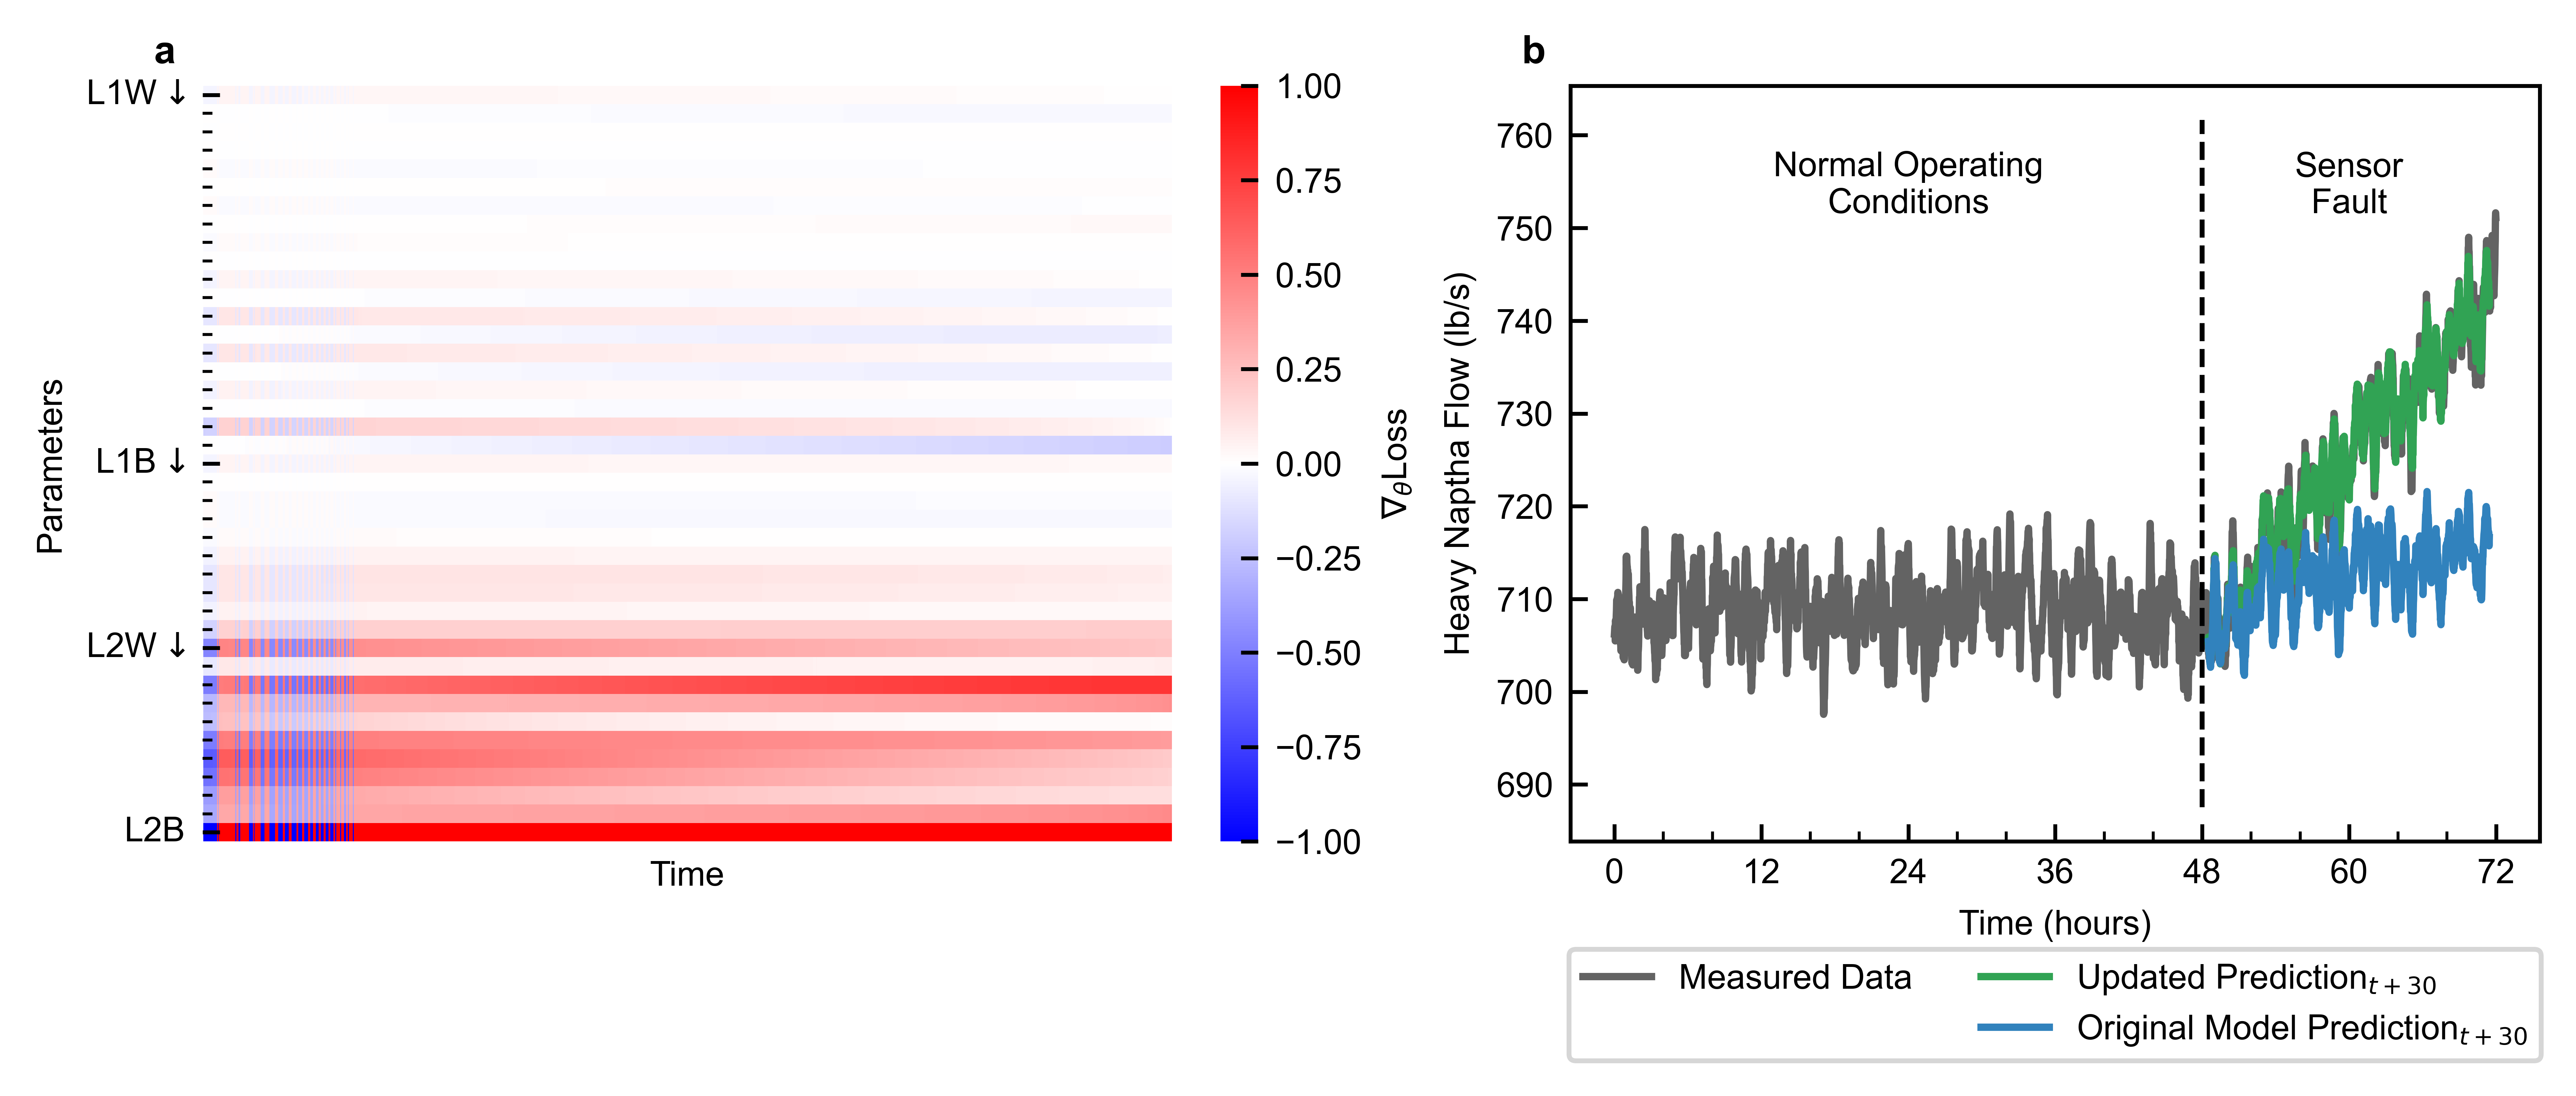

In [133]:
fig, axs = plt.subplots(1,2, figsize=(183*mm_to_inch, 3), dpi=1000)

# subplot 1: gradients
logger1 = h5_logger(os.path.join("results", "boundarylayer", "boundary_layer.h5"))
grads = logger1.get_dataset("control/gradients")
sns.heatmap(grads.T, ax=axs[0], cmap="bwr", cbar_kws={"label": r"$\nabla_\theta$Loss", }, center=0)
# y_major_indices = [0.5, 5.5, 10.5, 15.5, 20.5, 25.5, 30.5]
# y_major_labels = ["Layer 1 Weights (1)", "(6)", "Layer 1 Bias (1)", "(6)", "Layer 2 Weights (1)", "(6)", "Layer 2 Bias (1)"]
y_major_indices = [0.5, 20.5, 30.5, 40.5]
y_major_labels = [r"L1W$\downarrow$", r"L1B$\downarrow$", r"L2W$\downarrow$", "L2B"]
axs[0].set_yticks(y_major_indices, labels=y_major_labels, rotation=0)
axs[0].set_yticks(np.arange(40)+0.5, minor=True)
axs[0].set_ylabel("Parameters")
axs[0].set_xlabel("Time")
axs[0].set_xticks([])

# subplot2: heavy naptha flow drift
from utils.fcc import NOC_STABLE_PATH, NOC_VARYING_PATH, COLUMNS, X_COLUMNS_NAMES, U_COLUMNS_NAMES, FAULTY_CONDITIONS, FAULTY_NAPTHASENSOR_PATH
from utils.fcc import FCUDataset, DataLoader, graph_subplots
# get scaler ready
# import data
df_stable = pd.read_csv(NOC_STABLE_PATH, names=COLUMNS)
df_varying = pd.read_csv(NOC_VARYING_PATH, names=COLUMNS)
df = pd.concat([df_stable, df_varying], ignore_index=True)
# split and scale data
# 7 days train (2 stable, 5 varying) ~78%
# 1 day val ~11%
# 1 day test ~11%
train_val_idx = -2880
val_test_idx = -1440
prediction_horizon = 60
batch_size = 32

if MEASUREMENT_NOISE_LEVEL:
    noise_std = MEASUREMENT_NOISE_LEVEL / 3
    # Add Gaussian noise with st dev of 1/3% of the mean value of each variable
    data = default_rng.standard_normal(df.shape) * MEASUREMENT_NOISE_LEVEL/3 * df.values.mean(axis=0) + df.values

    df = pd.DataFrame(data, columns=df.columns)

# X_scaler = skp.QuantileTransformer(output_distribution='normal')
# U_scaler = skp.QuantileTransformer(output_distribution='normal')
# X_scaler = skp.RobustScaler(quantile_range=(10, 90))
# U_scaler = skp.RobustScaler(quantile_range=(10, 90))
# X_scaler = skp.MaxAbsScaler()
# U_scaler = skp.MaxAbsScaler()
# X_scaler = StandardScaler()
# U_scaler = StandardScaler()
X_scaler = skp.RobustScaler()
U_scaler = skp.RobustScaler()
train_dataset = FCUDataset(df, 
    prediction_horizon=prediction_horizon, 
    context_length=1, 
    train=True, 
    X_scaler=X_scaler, 
    U_scaler=U_scaler, 
    begin_split_index=0, 
    end_split_index=train_val_idx)
logger = h5_logger(os.path.join("results", "fcc", "Faulty Conditions", "FC_GEKFv2.h5"))
df_stable = pd.read_csv(NOC_STABLE_PATH, names=COLUMNS)
df_faulty = pd.read_csv(FAULTY_NAPTHASENSOR_PATH, names=COLUMNS)
df = pd.concat([df_stable, df_faulty], ignore_index=True)
data = default_rng.standard_normal(df.shape) * MEASUREMENT_NOISE_LEVEL/3 * df.values.mean(axis=0) + df.values
df = pd.DataFrame(data, columns=COLUMNS)
HN_idx = X_COLUMNS_NAMES.index("F.HN")
kf_30 = X_scaler.inverse_transform(logger.get_dataset("updating/"+"Heavy Naptha Flow Sensor Drift"+"/full/YP")[:,0,30,:]).T[HN_idx]
control_t30 = logger.get_dataset("updating/"+"Heavy Naptha Flow Sensor Drift"+"/control/YP")[0,:,30,[HN_idx]][0]
MEASUREMENT_NOISE_LEVEL = 0.0025
sorted_columns = sorted(X_COLUMNS_NAMES) + sorted(U_COLUMNS_NAMES)
fcc_results_dir = os.path.join("results", "fcc")
logger = h5_logger(os.path.join(fcc_results_dir, "Faulty Conditions", "FC_GEKFv2.h5"))
true_handle = axs[1].plot(np.arange(df.shape[0])/60, df["F.HN"], color=true_colors[0], label="Measured Data")
empty_entry = axs[1].plot([], [], color="white", label=" ")
kf_handle = axs[1].plot(np.arange(kf_30.shape[0])/60+30/60+48, kf_30, color=kalman_colors[0], linewidth=1.5, label=r"Updated Prediction$_{t+30}$")
original_handle = axs[1].plot(np.arange(control_t30.shape[0])/60+30/60+48, control_t30, color=model_colors[0], linewidth=1.5, label=r"Original Model Prediction$_{t+30}$")

axs[1].vlines(48, min(df["F.HN"])-10, max(df["F.HN"])+10, color="black", linestyle="--", linewidth=1)
axs[1].text(24, max(df["F.HN"]), "Normal Operating\nConditions", ha="center")
axs[1].text(60, max(df["F.HN"]), "Sensor\nFault", ha="center")
axs[1].set_xlabel("Time (hours)")
axs[1].set_ylabel("Heavy Naptha Flow (lb/s)")
axs[1].set_xticks([0, 12, 24, 36, 48, 60, 72])
axs[1].set_xticks(np.arange(72, step=4), minor=True)
axs[1].legend(bbox_to_anchor=(0.5, -0.12), loc="upper center", ncol=2)

axs[0].annotate("a", (-0.05, 1.03), xycoords="axes fraction", fontsize=8, fontweight="bold")
axs[1].annotate("b", (-0.05, 1.03), xycoords="axes fraction", fontsize=8, fontweight="bold")

fig.savefig(os.path.join(report_dir, "gradient_naptha_flow.eps"), bbox_inches='tight')

## Sandbox

In [143]:
import re

text = r"""\begin{landscape}
        \begin{table}
            \caption{Part 1 of FCC-Fractionator Results}
            \label{tab:fcc_results_1}
            \begin{tabular}{lllrrllll}
                \toprule
                Fault                          & Method         & Params. & MSE        & 95\% CI    & FSS        & 95\% CI    & Mean Time (s) & 95\% CI    \\
                \midrule
                -                              & Training       & -       & 2.2858e-01 & 7.3446e-02 & -          & -          & -             & -          \\
                -                              & Validation     & -       & 1.9714e-01 & 5.4009e-03 & -          & -          & -             & -          \\
                \midrule
                CAB Valve Leak                 & No Maintenance & -       & 1.0820e+00 & 2.2326e-02 & -          & -          & -             & -          \\
                CAB Valve Leak                 & Finetuning     & full    & 1.9565e-01 & 6.1422e-03 & 7.2415e-01 & 1.4812e-02 & 1.5875e+00    & 1.1517e-01 \\
                CAB Valve Leak                 & Finetuning     & Prop.95  & 2.2494e-01 & 1.1762e-02 & 7.0367e-01 & 1.5655e-02 & 1.5426e+00    & 1.1677e-01 \\
                CAB Valve Leak                 & Finetuning     & Prop.99  & 2.3210e-01 & 1.3312e-02 & 6.9916e-01 & 1.5828e-02 & 1.8069e+00    & 1.2471e-01 \\
                CAB Valve Leak                 & Finetuning     & Mag.95  & 2.1772e-01 & 9.8060e-03 & 7.0818e-01 & 1.5318e-02 & 2.0561e+00    & 1.3556e-01 \\
                CAB Valve Leak                 & Finetuning     & Mag.99  & 2.2022e-01 & 1.0479e-02 & 7.0684e-01 & 1.5424e-02 & 1.8135e+00    & 1.3062e-01 \\
                CAB Valve Leak                 & Updating       & full    & 1.9786e-01 & 9.1068e-03 & 7.2533e-01 & 1.5204e-02 & 7.4818e-01    & 1.3389e-03 \\
                CAB Valve Leak                 & Updating       & Prop.95  & 2.0919e-01 & 9.1226e-03 & 7.1843e-01 & 1.4850e-02 & 6.2338e-01    & 4.3430e-04 \\
                CAB Valve Leak                 & Updating       & Prop.99  & 2.1008e-01 & 8.8157e-03 & 7.1693e-01 & 1.4853e-02 & 5.8055e-01    & 1.0839e-03 \\
                CAB Valve Leak                 & Updating       & Mag.95  & 2.7196e-01 & 3.8912e-02 & 6.6303e-01 & 3.3941e-02 & 5.9998e-01    & 1.6162e-03 \\
                CAB Valve Leak                 & Updating       & Mag.99  & 2.5378e-01 & 2.3522e-02 & 6.7813e-01 & 2.3023e-02 & 5.9495e-01    & 1.6473e-03 \\
                \midrule
                Decreased Condenser Efficiency & No Maintenance & -       & 2.2849e-01 & 2.5593e-03 & -          & -          & -             & -          \\
                Decreased Condenser Efficiency & Finetuning     & full    & 1.7040e-01 & 3.9717e-04 & 2.2173e-01 & 8.3153e-03 & 8.1784e-01    & 8.7084e-02 \\
                Decreased Condenser Efficiency & Finetuning     & Prop.95  & 1.7077e-01 & 4.6047e-04 & 2.2030e-01 & 8.3225e-03 & 9.4395e-01    & 9.0861e-02 \\
                Decreased Condenser Efficiency & Finetuning     & Prop.99  & 1.7112e-01 & 4.6744e-04 & 2.1892e-01 & 8.2880e-03 & 1.0597e+00    & 9.9739e-02 \\
                Decreased Condenser Efficiency & Finetuning     & Mag.95  & 1.7097e-01 & 4.6100e-04 & 2.1924e-01 & 8.3764e-03 & 1.1013e+00    & 9.5548e-02 \\
                Decreased Condenser Efficiency & Finetuning     & Mag.99  & 1.7109e-01 & 4.7182e-04 & 2.1923e-01 & 8.2496e-03 & 1.0555e+00    & 9.8528e-02 \\
                Decreased Condenser Efficiency & Updating       & full    & 1.6499e-01 & 4.7353e-04 & 2.4611e-01 & 8.2568e-03 & 7.0269e-01    & 3.2961e-04 \\
                Decreased Condenser Efficiency & Updating       & Prop.95  & 1.6780e-01 & 4.8018e-04 & 2.3355e-01 & 8.3221e-03 & 5.7447e-01    & 3.5543e-03 \\
                Decreased Condenser Efficiency & Updating       & Prop.99  & 1.6900e-01 & 4.8920e-04 & 2.2847e-01 & 8.2842e-03 & 5.6503e-01    & 4.4142e-04 \\
                Decreased Condenser Efficiency & Updating       & Mag.95  & 1.6813e-01 & 4.8340e-04 & 2.3202e-01 & 8.3462e-03 & 5.6570e-01    & 1.6098e-03 \\
                Decreased Condenser Efficiency & Updating       & Mag.99  & 1.6943e-01 & 5.0287e-04 & 2.2695e-01 & 8.1927e-03 & 5.6524e-01    & 4.8120e-04 \\
                \midrule
                Heat Exchanger Fouling         & No Maintenance & -       & 7.7872e-01 & 2.7629e-02 & -          & -          & -             & -          \\
                Heat Exchanger Fouling         & Finetuning     & full    & 1.7611e-01 & 7.1871e-04 & 5.5694e-01 & 1.8109e-02 & 1.3235e+00    & 1.0952e-01 \\
                Heat Exchanger Fouling         & Finetuning     & Prop.95  & 1.8121e-01 & 1.0648e-03 & 5.5209e-01 & 1.8026e-02 & 2.0830e+00    & 1.2582e-01 \\
                Heat Exchanger Fouling         & Finetuning     & Prop.99  & 1.8531e-01 & 1.2664e-03 & 5.4797e-01 & 1.7944e-02 & 2.8707e+00    & 1.3877e-01 \\
                Heat Exchanger Fouling         & Finetuning     & Mag.95  & 1.7954e-01 & 9.8383e-04 & 5.5300e-01 & 1.8112e-02 & 2.0308e+00    & 1.3082e-01 \\
                Heat Exchanger Fouling         & Finetuning     & Mag.99  & 1.8055e-01 & 1.0280e-03 & 5.5187e-01 & 1.8098e-02 & 2.2107e+00    & 1.3625e-01 \\
                Heat Exchanger Fouling         & Updating       & full    & 1.6833e-01 & 6.8298e-04 & 5.7228e-01 & 1.7829e-02 & 7.3931e-01    & 4.1766e-03 \\
                Heat Exchanger Fouling         & Updating       & Prop.95  & 1.7398e-01 & 7.8964e-04 & 5.6345e-01 & 1.7974e-02 & 5.6607e-01    & 1.0917e-03 \\
                Heat Exchanger Fouling         & Updating       & Prop.99  & 1.7661e-01 & 8.6650e-04 & 5.5959e-01 & 1.7997e-02 & 5.6679e-01    & 5.8452e-04 \\
                Heat Exchanger Fouling         & Updating       & Mag.95  & 1.7282e-01 & 7.5622e-04 & 5.6408e-01 & 1.8046e-02 & 5.6995e-01    & 2.6068e-03 \\
                Heat Exchanger Fouling         & Updating       & Mag.99  & 1.7474e-01 & 7.9104e-04 & 5.6003e-01 & 1.8133e-02 & 5.8346e-01    & 1.1117e-03 \\
                % Heavy Naptha Flow Sensor Drift & No Maintenance & - & 1.9995e-01 & 1.5275e-03 & - & - & - & - \\
                % Heavy Naptha Flow Sensor Drift & retraining & full & 1.6933e-01 & 5.2727e-04 & 1.3777e-01 & 6.2148e-03 & 7.9557e-01 & 8.4901e-02 \\
                % Heavy Naptha Flow Sensor Drift & retraining & Prop.95 & 1.7060e-01 & 5.3188e-04 & 1.3233e-01 & 5.8983e-03 & 9.8887e-01 & 9.3178e-02 \\
                % Heavy Naptha Flow Sensor Drift & retraining & Prop.99 & 1.7054e-01 & 5.4508e-04 & 1.3259e-01 & 5.9484e-03 & 1.1264e+00 & 1.0328e-01 \\
                % Heavy Naptha Flow Sensor Drift & retraining & Mag.95 & 1.7038e-01 & 5.5995e-04 & 1.3284e-01 & 6.1827e-03 & 1.1203e+00 & 1.0191e-01 \\
                % Heavy Naptha Flow Sensor Drift & retraining & Mag.99 & 1.7060e-01 & 5.4396e-04 & 1.3225e-01 & 5.9552e-03 & 1.1190e+00 & 1.0239e-01 \\
                % Heavy Naptha Flow Sensor Drift & updating & full & 1.6485e-01 & 6.0120e-04 & 1.5979e-01 & 6.5344e-03 & 7.0761e-01 & 1.2636e-03 \\
                % Heavy Naptha Flow Sensor Drift & updating & Prop.95 & 1.6737e-01 & 5.9848e-04 & 1.4716e-01 & 6.5351e-03 & 5.7458e-01 & 2.1382e-03 \\
                % Heavy Naptha Flow Sensor Drift & updating & Prop.99 & 1.6819e-01 & 5.9751e-04 & 1.4329e-01 & 6.4515e-03 & 5.7767e-01 & 6.6518e-04 \\
                % Heavy Naptha Flow Sensor Drift & updating & Mag.95 & 1.6760e-01 & 5.9940e-04 & 1.4604e-01 & 6.5318e-03 & 5.7613e-01 & 9.0233e-04 \\
                % Heavy Naptha Flow Sensor Drift & updating & Mag.99 & 1.6826e-01 & 5.9952e-04 & 1.4295e-01 & 6.4578e-03 & 5.7301e-01 & 7.1910e-04 \\
                % Higher Pressure Drop & No Maintenance & - & 5.8419e+01 & 1.2995e+00 & - & - & - & - \\
                % Higher Pressure Drop & retraining & full & 2.9989e-01 & 2.8644e-02 & 9.2004e-01 & 1.3100e-02 & 3.2292e+00 & 1.4362e-01 \\
                % Higher Pressure Drop & retraining & Prop.95 & 4.0032e-01 & 4.5861e-02 & 9.1528e-01 & 1.3335e-02 & 4.8977e+00 & 5.9930e-02 \\
                % Higher Pressure Drop & retraining & Prop.99 & 4.1864e-01 & 4.5468e-02 & 9.1330e-01 & 1.3453e-02 & 5.4246e+00 & 6.4408e-02 \\
                % Higher Pressure Drop & retraining & Mag.95 & 3.7784e-01 & 4.5928e-02 & 9.1663e-01 & 1.3283e-02 & 4.9987e+00 & 9.2403e-02 \\
                % Higher Pressure Drop & retraining & Mag.99 & 3.8487e-01 & 4.5973e-02 & 9.1577e-01 & 1.3388e-02 & 5.0694e+00 & 7.0485e-02 \\
                % Higher Pressure Drop & updating & full & 4.4462e-01 & 4.3729e-02 & 9.2038e-01 & 1.2747e-02 & 7.6581e-01 & 1.4917e-03 \\
                % Higher Pressure Drop & updating & Prop.95 & 3.4164e-01 & 2.3384e-02 & 9.2006e-01 & 1.3014e-02 & 6.2386e-01 & 8.4890e-04 \\
                % Higher Pressure Drop & updating & Prop.99 & 3.5197e-01 & 2.3412e-02 & 9.1898e-01 & 1.3127e-02 & 7.8509e-01 & 2.9385e-02 \\
                % Higher Pressure Drop & updating & Mag.95 & 3.9371e-01 & 2.7744e-02 & 9.1953e-01 & 1.3008e-02 & 6.3863e-01 & 1.8718e-03 \\
                % Higher Pressure Drop & updating & Mag.99 & 3.9231e-01 & 3.2431e-02 & 9.1845e-01 & 1.3184e-02 & 6.3380e-01 & 1.1499e-03 \\
                \bottomrule
            \end{tabular}
        \end{table}

        \begin{table}
            \caption{Part 2 of FCC-Fractionator Results}
            \label{tab:fcc_results_2}
            \begin{tabular}{lllrrllll}
                \toprule
                Fault                          & Method         & Params. & MSE        & 95\% CI    & FSS        & 95\% CI    & Mean Time (s) & 95\% CI    \\
                \midrule
                -                              & Training       & -       & 2.2858e-01 & 7.3446e-02 & -          & -          & -             & -          \\
                -                              & Validation     & -       & 1.9714e-01 & 5.4009e-03 & -          & -          & -             & -          \\
                \midrule
                % CAB Valve Leak & No Maintenance & - & 1.0820e+00 & 2.2326e-02 & - & - & - & - \\
                % CAB Valve Leak & retraining & full & 1.9565e-01 & 6.1422e-03 & 7.2415e-01 & 1.4812e-02 & 1.5875e+00 & 1.1517e-01 \\
                % CAB Valve Leak & retraining & Prop.95 & 2.2494e-01 & 1.1762e-02 & 7.0367e-01 & 1.5655e-02 & 1.5426e+00 & 1.1677e-01 \\
                % CAB Valve Leak & retraining & Prop.99 & 2.3210e-01 & 1.3312e-02 & 6.9916e-01 & 1.5828e-02 & 1.8069e+00 & 1.2471e-01 \\
                % CAB Valve Leak & retraining & Mag.95 & 2.1772e-01 & 9.8060e-03 & 7.0818e-01 & 1.5318e-02 & 2.0561e+00 & 1.3556e-01 \\
                % CAB Valve Leak & retraining & Mag.99 & 2.2022e-01 & 1.0479e-02 & 7.0684e-01 & 1.5424e-02 & 1.8135e+00 & 1.3062e-01 \\
                % CAB Valve Leak & updating & full & 1.9786e-01 & 9.1068e-03 & 7.2533e-01 & 1.5204e-02 & 7.4818e-01 & 1.3389e-03 \\
                % CAB Valve Leak & updating & Prop.95 & 2.0919e-01 & 9.1226e-03 & 7.1843e-01 & 1.4850e-02 & 6.2338e-01 & 4.3430e-04 \\
                % CAB Valve Leak & updating & Prop.99 & 2.1008e-01 & 8.8157e-03 & 7.1693e-01 & 1.4853e-02 & 5.8055e-01 & 1.0839e-03 \\
                % CAB Valve Leak & updating & Mag.95 & 2.7196e-01 & 3.8912e-02 & 6.6303e-01 & 3.3941e-02 & 5.9998e-01 & 1.6162e-03 \\
                % CAB Valve Leak & updating & Mag.99 & 2.5378e-01 & 2.3522e-02 & 6.7813e-01 & 2.3023e-02 & 5.9495e-01 & 1.6473e-03 \\
                % Decreased Condenser Efficiency & No Maintenance & - & 2.2849e-01 & 2.5593e-03 & - & - & - & - \\
                % Decreased Condenser Efficiency & retraining & full & 1.7040e-01 & 3.9717e-04 & 2.2173e-01 & 8.3153e-03 & 8.1784e-01 & 8.7084e-02 \\
                % Decreased Condenser Efficiency & retraining & Prop.95 & 1.7077e-01 & 4.6047e-04 & 2.2030e-01 & 8.3225e-03 & 9.4395e-01 & 9.0861e-02 \\
                % Decreased Condenser Efficiency & retraining & Prop.99 & 1.7112e-01 & 4.6744e-04 & 2.1892e-01 & 8.2880e-03 & 1.0597e+00 & 9.9739e-02 \\
                % Decreased Condenser Efficiency & retraining & Mag.95 & 1.7097e-01 & 4.6100e-04 & 2.1924e-01 & 8.3764e-03 & 1.1013e+00 & 9.5548e-02 \\
                % Decreased Condenser Efficiency & retraining & Mag.99 & 1.7109e-01 & 4.7182e-04 & 2.1923e-01 & 8.2496e-03 & 1.0555e+00 & 9.8528e-02 \\
                % Decreased Condenser Efficiency & updating & full & 1.6499e-01 & 4.7353e-04 & 2.4611e-01 & 8.2568e-03 & 7.0269e-01 & 3.2961e-04 \\
                % Decreased Condenser Efficiency & updating & Prop.95 & 1.6780e-01 & 4.8018e-04 & 2.3355e-01 & 8.3221e-03 & 5.7447e-01 & 3.5543e-03 \\
                % Decreased Condenser Efficiency & updating & Prop.99 & 1.6900e-01 & 4.8920e-04 & 2.2847e-01 & 8.2842e-03 & 5.6503e-01 & 4.4142e-04 \\
                % Decreased Condenser Efficiency & updating & Mag.95 & 1.6813e-01 & 4.8340e-04 & 2.3202e-01 & 8.3462e-03 & 5.6570e-01 & 1.6098e-03 \\
                % Decreased Condenser Efficiency & updating & Mag.99 & 1.6943e-01 & 5.0287e-04 & 2.2695e-01 & 8.1927e-03 & 5.6524e-01 & 4.8120e-04 \\
                % Heat Exchanger Fouling & No Maintenance & - & 7.7872e-01 & 2.7629e-02 & - & - & - & - \\
                % Heat Exchanger Fouling & retraining & full & 1.7611e-01 & 7.1871e-04 & 5.5694e-01 & 1.8109e-02 & 1.3235e+00 & 1.0952e-01 \\
                % Heat Exchanger Fouling & retraining & Prop.95 & 1.8121e-01 & 1.0648e-03 & 5.5209e-01 & 1.8026e-02 & 2.0830e+00 & 1.2582e-01 \\
                % Heat Exchanger Fouling & retraining & Prop.99 & 1.8531e-01 & 1.2664e-03 & 5.4797e-01 & 1.7944e-02 & 2.8707e+00 & 1.3877e-01 \\
                % Heat Exchanger Fouling & retraining & Mag.95 & 1.7954e-01 & 9.8383e-04 & 5.5300e-01 & 1.8112e-02 & 2.0308e+00 & 1.3082e-01 \\
                % Heat Exchanger Fouling & retraining & Mag.99 & 1.8055e-01 & 1.0280e-03 & 5.5187e-01 & 1.8098e-02 & 2.2107e+00 & 1.3625e-01 \\
                % Heat Exchanger Fouling & updating & full & 1.6833e-01 & 6.8298e-04 & 5.7228e-01 & 1.7829e-02 & 7.3931e-01 & 4.1766e-03 \\
                % Heat Exchanger Fouling & updating & Prop.95 & 1.7398e-01 & 7.8964e-04 & 5.6345e-01 & 1.7974e-02 & 5.6607e-01 & 1.0917e-03 \\
                % Heat Exchanger Fouling & updating & Prop.99 & 1.7661e-01 & 8.6650e-04 & 5.5959e-01 & 1.7997e-02 & 5.6679e-01 & 5.8452e-04 \\
                % Heat Exchanger Fouling & updating & Mag.95 & 1.7282e-01 & 7.5622e-04 & 5.6408e-01 & 1.8046e-02 & 5.6995e-01 & 2.6068e-03 \\
                % Heat Exchanger Fouling & updating & Mag.99 & 1.7474e-01 & 7.9104e-04 & 5.6003e-01 & 1.8133e-02 & 5.8346e-01 & 1.1117e-03 \\
                Heavy Naptha Flow Sensor Drift & No Maintenance & -       & 1.9995e-01 & 1.5275e-03 & -          & -          & -             & -          \\
                Heavy Naptha Flow Sensor Drift & retraining     & full    & 1.6933e-01 & 5.2727e-04 & 1.3777e-01 & 6.2148e-03 & 7.9557e-01    & 8.4901e-02 \\
                Heavy Naptha Flow Sensor Drift & retraining     & Prop.95  & 1.7060e-01 & 5.3188e-04 & 1.3233e-01 & 5.8983e-03 & 9.8887e-01    & 9.3178e-02 \\
                Heavy Naptha Flow Sensor Drift & retraining     & Prop.99  & 1.7054e-01 & 5.4508e-04 & 1.3259e-01 & 5.9484e-03 & 1.1264e+00    & 1.0328e-01 \\
                Heavy Naptha Flow Sensor Drift & retraining     & Mag.95  & 1.7038e-01 & 5.5995e-04 & 1.3284e-01 & 6.1827e-03 & 1.1203e+00    & 1.0191e-01 \\
                Heavy Naptha Flow Sensor Drift & retraining     & Mag.99  & 1.7060e-01 & 5.4396e-04 & 1.3225e-01 & 5.9552e-03 & 1.1190e+00    & 1.0239e-01 \\
                Heavy Naptha Flow Sensor Drift & updating       & full    & 1.6485e-01 & 6.0120e-04 & 1.5979e-01 & 6.5344e-03 & 7.0761e-01    & 1.2636e-03 \\
                Heavy Naptha Flow Sensor Drift & updating       & Prop.95  & 1.6737e-01 & 5.9848e-04 & 1.4716e-01 & 6.5351e-03 & 5.7458e-01    & 2.1382e-03 \\
                Heavy Naptha Flow Sensor Drift & updating       & Prop.99  & 1.6819e-01 & 5.9751e-04 & 1.4329e-01 & 6.4515e-03 & 5.7767e-01    & 6.6518e-04 \\
                Heavy Naptha Flow Sensor Drift & updating       & Mag.95  & 1.6760e-01 & 5.9940e-04 & 1.4604e-01 & 6.5318e-03 & 5.7613e-01    & 9.0233e-04 \\
                Heavy Naptha Flow Sensor Drift & updating       & Mag.99  & 1.6826e-01 & 5.9952e-04 & 1.4295e-01 & 6.4578e-03 & 5.7301e-01    & 7.1910e-04 \\
                \midrule
                Higher Pressure Drop           & No Maintenance & -       & 5.8419e+01 & 1.2995e+00 & -          & -          & -             & -          \\
                Higher Pressure Drop           & retraining     & full    & 2.9989e-01 & 2.8644e-02 & 9.2004e-01 & 1.3100e-02 & 3.2292e+00    & 1.4362e-01 \\
                Higher Pressure Drop           & retraining     & Prop.95  & 4.0032e-01 & 4.5861e-02 & 9.1528e-01 & 1.3335e-02 & 4.8977e+00    & 5.9930e-02 \\
                Higher Pressure Drop           & retraining     & Prop.99  & 4.1864e-01 & 4.5468e-02 & 9.1330e-01 & 1.3453e-02 & 5.4246e+00    & 6.4408e-02 \\
                Higher Pressure Drop           & retraining     & Mag.95  & 3.7784e-01 & 4.5928e-02 & 9.1663e-01 & 1.3283e-02 & 4.9987e+00    & 9.2403e-02 \\
                Higher Pressure Drop           & retraining     & Mag.99  & 3.8487e-01 & 4.5973e-02 & 9.1577e-01 & 1.3388e-02 & 5.0694e+00    & 7.0485e-02 \\
                Higher Pressure Drop           & updating       & full    & 4.4462e-01 & 4.3729e-02 & 9.2038e-01 & 1.2747e-02 & 7.6581e-01    & 1.4917e-03 \\
                Higher Pressure Drop           & updating       & Prop.95  & 3.4164e-01 & 2.3384e-02 & 9.2006e-01 & 1.3014e-02 & 6.2386e-01    & 8.4890e-04 \\
                Higher Pressure Drop           & updating       & Prop.99  & 3.5197e-01 & 2.3412e-02 & 9.1898e-01 & 1.3127e-02 & 7.8509e-01    & 2.9385e-02 \\
                Higher Pressure Drop           & updating       & Mag.95  & 3.9371e-01 & 2.7744e-02 & 9.1953e-01 & 1.3008e-02 & 6.3863e-01    & 1.8718e-03 \\
                Higher Pressure Drop           & updating       & Mag.99  & 3.9231e-01 & 3.2431e-02 & 9.1845e-01 & 1.3184e-02 & 6.3380e-01    & 1.1499e-03 \\
                \bottomrule
            \end{tabular}
        \end{table}
    \end{landscape}"""
pattern = r"(\d+.\d+)e-(\d+)"
replacement = r"$\1\\times10^{-\2}$"
new_text = re.sub(pattern, replacement, text)
print(new_text)

\begin{landscape}
        \begin{table}
            \caption{Part 1 of FCC-Fractionator Results}
            \label{tab:fcc_results_1}
            \begin{tabular}{lllrrllll}
                \toprule
                Fault                          & Method         & Params. & MSE        & 95\% CI    & FSS        & 95\% CI    & Mean Time (s) & 95\% CI    \\
                \midrule
                -                              & Training       & -       & $2.2858\times10^{-01}$ & $7.3446\times10^{-02}$ & -          & -          & -             & -          \\
                -                              & Validation     & -       & $1.9714\times10^{-01}$ & $5.4009\times10^{-03}$ & -          & -          & -             & -          \\
                \midrule
                CAB Valve Leak                 & No Maintenance & -       & 1.0820e+00 & $2.2326\times10^{-02}$ & -          & -          & -             & -          \\
                CAB Valve Leak                 & Finetuning